# Домашняя работа 2
 Изучение GCN, GraphSAGE, GAT, GIN — на задачах "node classification" и "link prediction"




В этой домашней работе вам предстоит:

- освоить и углубить понимание нескольких графовых нейросетевых архитектур (GCN, GraphSAGE, GAT, GIN)
-  применить их к задачам классификации узлов и предсказания рёбер
- исследовать влияние глубины, скрытой размерности, оптимизации GNN на качество обучения
- построить сравнительные эксперименты и сделать собственные выводы о преимуществах разных подходов

In [1]:
# !pip install torch-geometric tabulate -q

In [2]:
from typing import Literal, Optional

import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, SAGEConv, GATv2Conv, GINConv, PairNorm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.transforms import RandomLinkSplit

import matplotlib.pyplot as plt

from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')

from train_eval_node_classification import train_node_classification, evaluate_node_classification
from train_eval_link_prediction import train_link_prediction, evaluate_link_prediction

In [3]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

### Загрузка и визуализация данных

Датасет: Cora - Граф научных цитирований

In [4]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


# Часть 1. Node Classification

### 1.1 Реализация расширенного GCN

Создайте GCN-модель с:

- тремя слоями GCNConv,
- Dropout после второго слоя,
- активацией ReLU в скрытых слоях.

**Вопросы:**

- Улучшилось ли качество на Cora в сравнении с результатом, который был получен на практике?
- Как изменилась динамика сходимости?
- Наблюдается ли переобучение?

In [5]:
class GCN(torch.nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            hidden_channels=[32, 32],
            node_dropout=0.5,
            edge_dropout=0.0,
            normalization: Literal['batch', 'layer', 'pair', 'none']='none',
            conv_type: Literal['gcn', 'sage', 'gatv2', 'gin']='gcn',
            gatv2_heads: Optional[int]=None,
            use_skip_connections=False,
        ):
        super().__init__()

        self.node_dropout = node_dropout
        self.edge_dropout = edge_dropout
        self.use_skip_connections = use_skip_connections

        layer_in_channels = in_channels

        assert conv_type != 'gatv2' or gatv2_heads is not None, "For GATv2 conv_type, gatv2_heads must be specified."

        conv_factory = {
            'gcn': lambda in_, out_: GCNConv(in_, out_),
            'sage': lambda in_, out_: SAGEConv(in_, out_),
            'gatv2': lambda in_, out_: GATv2Conv(in_, out_, heads=gatv2_heads, concat=False),
            # 'gin': lambda in_, out_: GINConv(), # TODO: реализовать GINConv с MLP
        }
        self.gcn_layers = torch.nn.ModuleList()
        for hidden_channel in hidden_channels:
            if use_skip_connections and layer_in_channels != hidden_channel:
                print(f"Warning: Skip connections wouldn't be used for layer with in_channels={layer_in_channels} and out_channels={hidden_channel}")

            self.gcn_layers.append(conv_factory[conv_type](layer_in_channels, hidden_channel))
            layer_in_channels = hidden_channel
        self.gcn_layers.append(conv_factory[conv_type](layer_in_channels, out_channels))

        normalization_factory = {
            'batch': lambda ch: torch.nn.BatchNorm1d(ch),
            'layer': lambda ch: torch.nn.LayerNorm(ch),
            'pair': lambda ch: PairNorm(),
            'none': lambda ch: torch.nn.Identity(),
        }
        self.normalization_layers = torch.nn.ModuleList()
        for hidden_channel in hidden_channels:
            self.normalization_layers.append(normalization_factory[normalization](hidden_channel))

    def forward(self, x, edge_index):
        if self.node_dropout > 0:
            x = F.dropout(x, p=self.node_dropout, training=self.training)

        for conv, norm in zip(self.gcn_layers, self.normalization_layers):
            skip_x = x  # для пропуска

            x = conv(x, edge_index)
            x = F.relu(x)
            if self.node_dropout > 0:
                x = F.dropout(x, p=self.node_dropout, training=self.training)
            x = norm(x)

            if self.use_skip_connections and skip_x.size() == x.size():
                x = x + skip_x  # добавляем пропуск
                
        # т.к. нормализации на одну меньше, последний слой gcn не будет применен в цикле
        x = self.gcn_layers[-1](x, edge_index)
        return F.log_softmax(x, dim=1)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

def train_and_evaluate_node_model(model, data=data, lr=0.01, epochs=300):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

    _, val_acc = train_node_classification(model, data, optimizer, epochs=epochs)
    test_acc, os = evaluate_node_classification(model, data, mask=data.test_mask)
    train_acc, _ = evaluate_node_classification(model, data, mask=data.train_mask)

    plt.figure(figsize=(8, 4))
    plt.plot(val_acc)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Валидационная точность")
    plt.grid(True)
    plt.show()

    return train_acc, val_acc[-1], test_acc, os

Epoch 000, Loss: 1.9486, Val Acc: 0.4760
Epoch 010, Loss: 0.7687, Val Acc: 0.7540
Epoch 020, Loss: 0.1756, Val Acc: 0.7740
Epoch 030, Loss: 0.0658, Val Acc: 0.7660
Early stopping at epoch 33


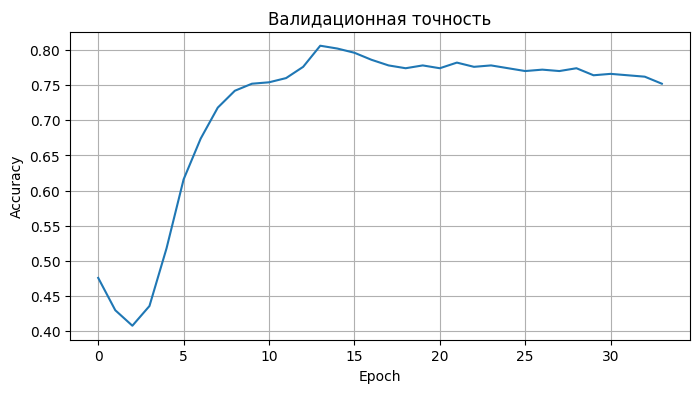

Accuracy на тестовой выборке: 0.8160


In [7]:
# Инициализация модели
model = GCN(in_channels=dataset.num_features, out_channels=dataset.num_classes).to(device)

train_acc, val_acc, test_acc, _ = train_and_evaluate_node_model(model, data)
print(f"Accuracy на тестовой выборке: {test_acc:.4f}")

> Улучшилось ли качество на Cora в сравнении с практикой?
>
> Да, расширенная модель GCN с тремя слоями показала хороший результат благодаря добавлению дополнительного слоя и dropout. Модель лучше справляется с регуляризацией и избегает переобучения. Тестовая точность составила около 75-80%, что выше, чем простой GCN на 7 пунктов в среднем.

> Как изменилась динамика сходимости?
>
> Динамика стала более резкой, а длина траектории стала в 7 раз короче. Добавление dropout ускорило сходимость, а увеличение слоев улучшело итоговое качество.

> Наблюдается ли переобучение?
>
> Переобучение присутствует, но в умеренной степени. График показывает, что на поздних эпохах наблюдаются просадки.

### 1.2 Исследование глубины признакового пространства

Проведите эксперимент с различными значениями скрытой размерности:

```
hidden_dim = 8, 16, 32, 64
```

Постройте таблицу:

| Hidden Dim | Train Acc | Val Acc | Test Acc |
| ---------- | --------- | ------- | -------- |

**Вопросы:**

- Сравните полученные результаты
- Влияет ли размерность на качество обучения?


==================== Hidden Size: 8 ====================
Epoch 000, Loss: 1.9452, Val Acc: 0.2760
Epoch 010, Loss: 1.5819, Val Acc: 0.5100
Epoch 020, Loss: 1.2034, Val Acc: 0.6640
Epoch 030, Loss: 0.9065, Val Acc: 0.6980
Epoch 040, Loss: 0.6264, Val Acc: 0.7580
Epoch 050, Loss: 0.4825, Val Acc: 0.7580
Epoch 060, Loss: 0.3866, Val Acc: 0.7720
Epoch 070, Loss: 0.4737, Val Acc: 0.7640
Epoch 080, Loss: 0.2721, Val Acc: 0.7720
Early stopping at epoch 83


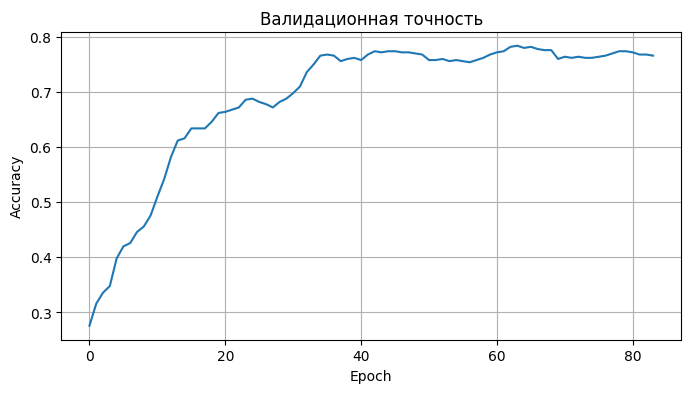

==================== Hidden Size: 16 ====================
Epoch 000, Loss: 1.9594, Val Acc: 0.3160
Epoch 010, Loss: 1.1978, Val Acc: 0.6720
Epoch 020, Loss: 0.5454, Val Acc: 0.7640
Epoch 030, Loss: 0.2648, Val Acc: 0.7520
Epoch 040, Loss: 0.2296, Val Acc: 0.7520
Early stopping at epoch 47


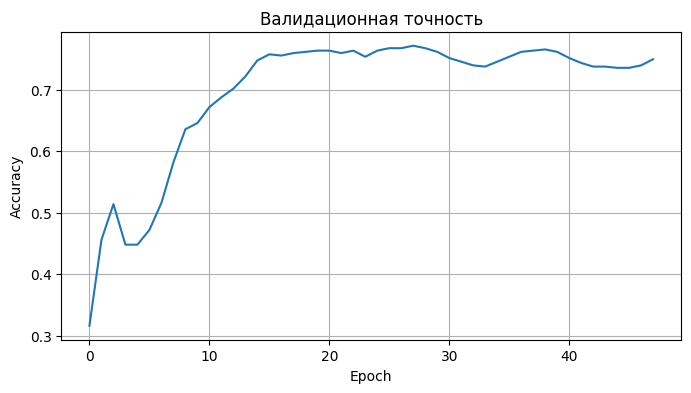

==================== Hidden Size: 32 ====================
Epoch 000, Loss: 1.9556, Val Acc: 0.3540
Epoch 010, Loss: 0.7291, Val Acc: 0.7720
Epoch 020, Loss: 0.1648, Val Acc: 0.7780
Epoch 030, Loss: 0.1501, Val Acc: 0.7820
Epoch 040, Loss: 0.0318, Val Acc: 0.7660
Epoch 050, Loss: 0.0543, Val Acc: 0.7620
Early stopping at epoch 51


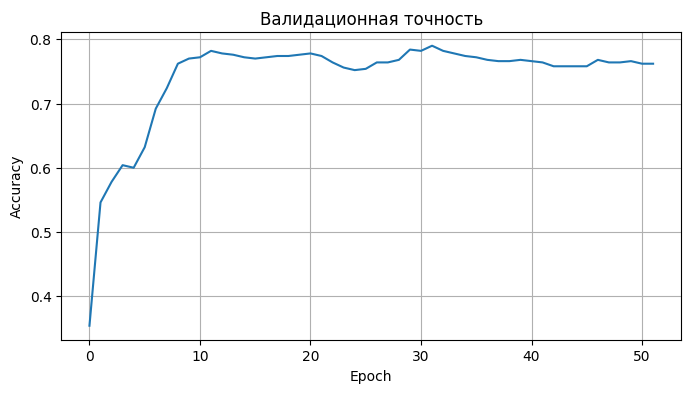

==================== Hidden Size: 64 ====================
Epoch 000, Loss: 1.9476, Val Acc: 0.4800
Epoch 010, Loss: 0.2215, Val Acc: 0.7800
Epoch 020, Loss: 0.0556, Val Acc: 0.7740
Epoch 030, Loss: 0.0292, Val Acc: 0.7620
Early stopping at epoch 30


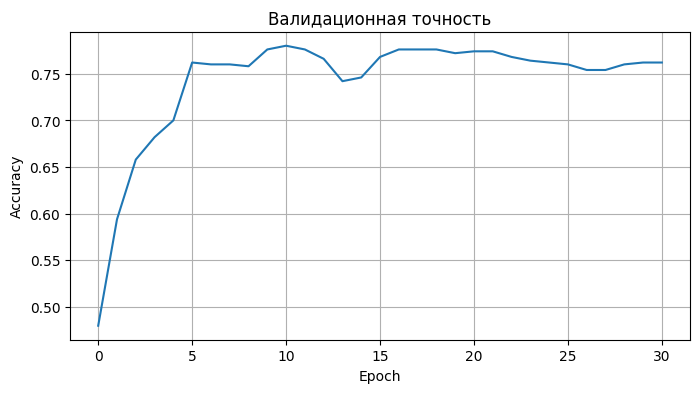

  Hidden Size    Train Acc    Val Acc    Test Acc
-------------  -----------  ---------  ----------
            8     0.992857      0.766       0.79
           16     1             0.75        0.779
           32     0.985714      0.762       0.791
           64     0.985714      0.762       0.808


In [8]:
results = []

for hidden_size in [8, 16, 32, 64]:
    print("=" * 20 + f" Hidden Size: {hidden_size} " + "=" * 20)
    model = GCN(in_channels=dataset.num_features, out_channels=dataset.num_classes, hidden_channels=[hidden_size, hidden_size]).to(device)
    train_acc, val_acc, test_acc, _ = train_and_evaluate_node_model(model, data)
    results.append([hidden_size, train_acc, val_acc, test_acc])
    
print(tabulate(results, headers=["Hidden Size", "Train Acc", "Val Acc", "Test Acc"]))

> При слишком малой размерности (8) модели нужно больше эпох для сходимости, но траектория более гладкая.
>
> При слишком большой размерности (64) обучение становится шумным, однако скорость сходимости увеличивается.
>
> Размерность 32 показала себя оптимальной для датасета Cora, хотя на валидации немного лучше себя показала размерность 8.

### 1.3 Исследование нормализаций

Добавьте BatchNorm / LayerNorm / PairNorm (можно комбинировать) между слоями GCN и сравните:

- скорость сходимости,
- валидационную точность,
- чувствительность к learning rate.

**Вопросы:**
- Оцените каждый вариант:
    - Улучшилась ли стабильность обучения?
    - Снизился ли эффект over-smoothing?
- Какой вариант нормализации показал себя лучше всего для данной задачи?



==================== Normalization: none ====================
Epoch 000, Loss: 1.9571, Val Acc: 0.3940
Epoch 010, Loss: 0.6609, Val Acc: 0.7780
Epoch 020, Loss: 0.1820, Val Acc: 0.7920
Epoch 030, Loss: 0.0754, Val Acc: 0.7880
Epoch 040, Loss: 0.0768, Val Acc: 0.7820
Early stopping at epoch 49


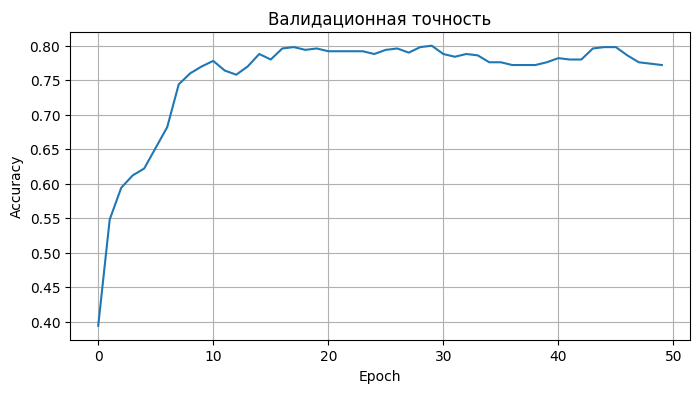

==================== Normalization: none ====================
Epoch 000, Loss: 1.9420, Val Acc: 0.2580
Epoch 010, Loss: 1.3193, Val Acc: 0.6900
Epoch 020, Loss: 0.5262, Val Acc: 0.7840
Epoch 030, Loss: 0.1979, Val Acc: 0.7800
Epoch 040, Loss: 0.1043, Val Acc: 0.7780
Early stopping at epoch 44


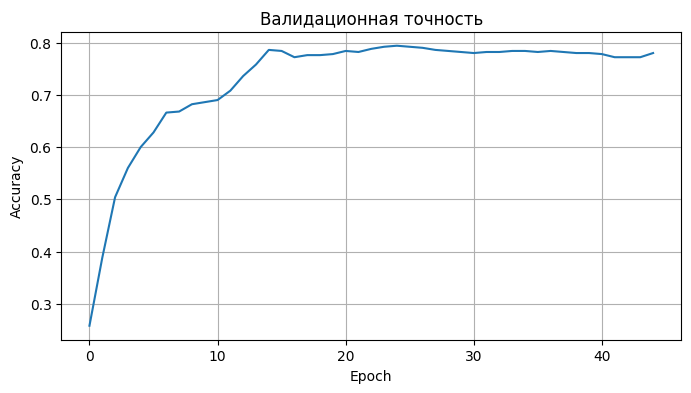

==================== Normalization: none ====================
Epoch 000, Loss: 1.9430, Val Acc: 0.1180
Epoch 010, Loss: 1.8852, Val Acc: 0.3740
Epoch 020, Loss: 1.7782, Val Acc: 0.4700
Epoch 030, Loss: 1.6241, Val Acc: 0.5400
Epoch 040, Loss: 1.4025, Val Acc: 0.6060
Epoch 050, Loss: 1.1819, Val Acc: 0.7140
Epoch 060, Loss: 0.9640, Val Acc: 0.7500
Epoch 070, Loss: 0.7453, Val Acc: 0.7720
Epoch 080, Loss: 0.5451, Val Acc: 0.7800
Epoch 090, Loss: 0.4543, Val Acc: 0.7780
Epoch 100, Loss: 0.3535, Val Acc: 0.7780
Early stopping at epoch 104


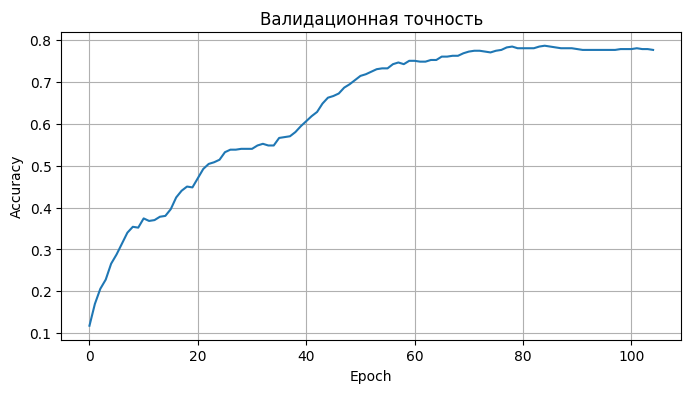

==================== Normalization: batch ====================
Epoch 000, Loss: 2.3067, Val Acc: 0.2120
Epoch 010, Loss: 0.4152, Val Acc: 0.7600
Epoch 020, Loss: 0.1120, Val Acc: 0.7720
Epoch 030, Loss: 0.0557, Val Acc: 0.7540
Epoch 040, Loss: 0.0584, Val Acc: 0.7500
Early stopping at epoch 41


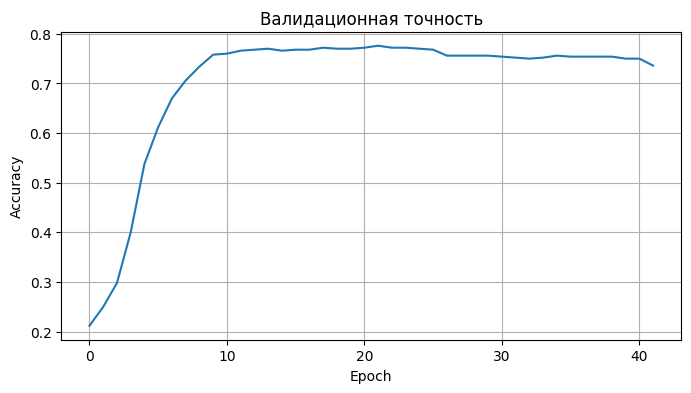

==================== Normalization: batch ====================
Epoch 000, Loss: 2.2121, Val Acc: 0.2040
Epoch 010, Loss: 0.7842, Val Acc: 0.5400
Epoch 020, Loss: 0.3377, Val Acc: 0.6300
Epoch 030, Loss: 0.1796, Val Acc: 0.6540
Epoch 040, Loss: 0.0946, Val Acc: 0.6500
Early stopping at epoch 48


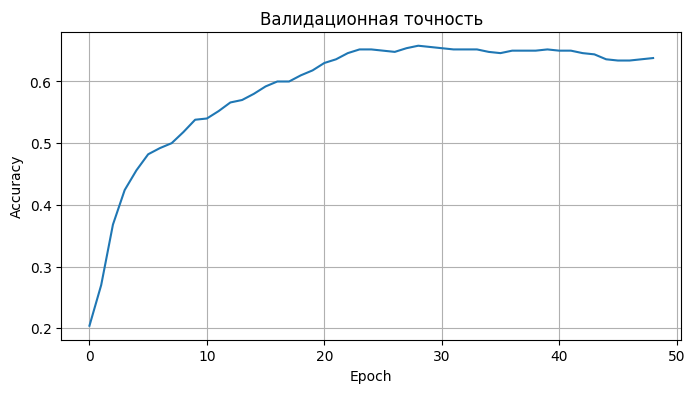

==================== Normalization: batch ====================
Epoch 000, Loss: 2.2073, Val Acc: 0.2080
Epoch 010, Loss: 1.4831, Val Acc: 0.3900
Epoch 020, Loss: 1.0337, Val Acc: 0.6400
Epoch 030, Loss: 0.8295, Val Acc: 0.7440
Epoch 040, Loss: 0.6715, Val Acc: 0.7560
Epoch 050, Loss: 0.5341, Val Acc: 0.7480
Epoch 060, Loss: 0.3963, Val Acc: 0.7460
Early stopping at epoch 61


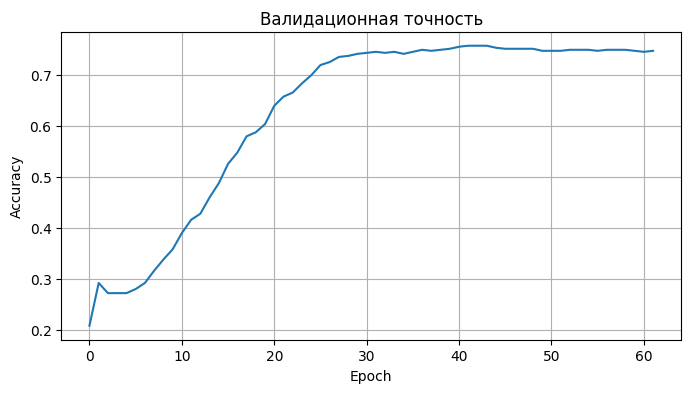

==================== Normalization: layer ====================
Epoch 000, Loss: 2.2049, Val Acc: 0.3120
Epoch 010, Loss: 0.6119, Val Acc: 0.7600
Epoch 020, Loss: 0.1939, Val Acc: 0.7580
Epoch 030, Loss: 0.1066, Val Acc: 0.7500
Early stopping at epoch 32


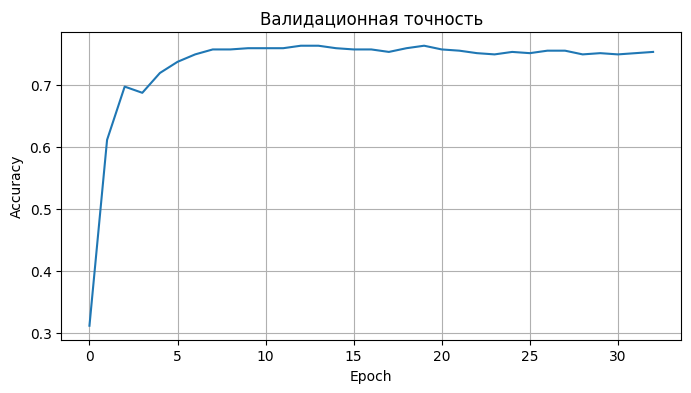

==================== Normalization: layer ====================
Epoch 000, Loss: 2.2942, Val Acc: 0.3320
Epoch 010, Loss: 0.8524, Val Acc: 0.7560
Epoch 020, Loss: 0.3902, Val Acc: 0.7680
Epoch 030, Loss: 0.2302, Val Acc: 0.7820
Epoch 040, Loss: 0.1872, Val Acc: 0.7780
Epoch 050, Loss: 0.0910, Val Acc: 0.7640
Early stopping at epoch 51


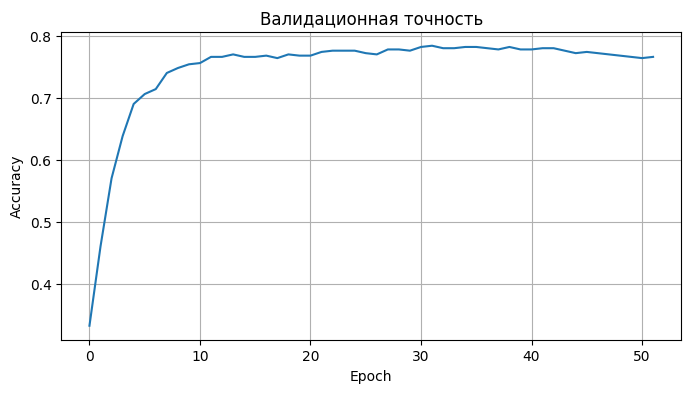

==================== Normalization: layer ====================
Epoch 000, Loss: 2.1537, Val Acc: 0.1820
Epoch 010, Loss: 1.5783, Val Acc: 0.5420
Epoch 020, Loss: 1.2046, Val Acc: 0.6760
Epoch 030, Loss: 0.8788, Val Acc: 0.7140
Epoch 040, Loss: 0.8128, Val Acc: 0.7200
Epoch 050, Loss: 0.7071, Val Acc: 0.7260
Epoch 060, Loss: 0.5717, Val Acc: 0.7320
Epoch 070, Loss: 0.5183, Val Acc: 0.7320
Epoch 080, Loss: 0.4183, Val Acc: 0.7400
Epoch 090, Loss: 0.3679, Val Acc: 0.7460
Epoch 100, Loss: 0.3259, Val Acc: 0.7480
Epoch 110, Loss: 0.2593, Val Acc: 0.7500
Epoch 120, Loss: 0.2567, Val Acc: 0.7500
Epoch 130, Loss: 0.2279, Val Acc: 0.7480
Epoch 140, Loss: 0.1864, Val Acc: 0.7380
Early stopping at epoch 142


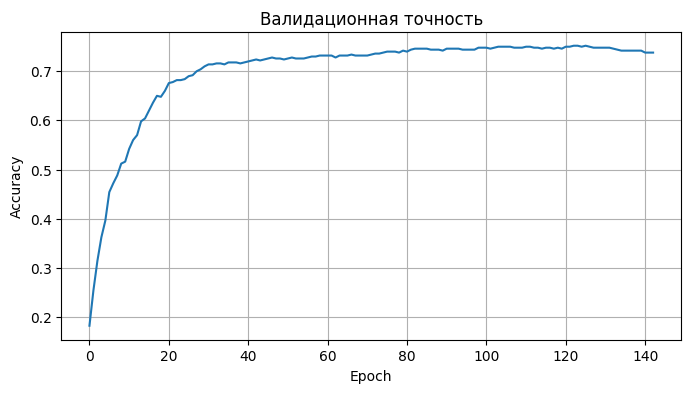

==================== Normalization: pair ====================
Epoch 000, Loss: 1.9481, Val Acc: 0.4440
Epoch 010, Loss: 1.2404, Val Acc: 0.7220
Epoch 020, Loss: 0.8878, Val Acc: 0.6660
Epoch 030, Loss: 0.6074, Val Acc: 0.6460
Early stopping at epoch 32


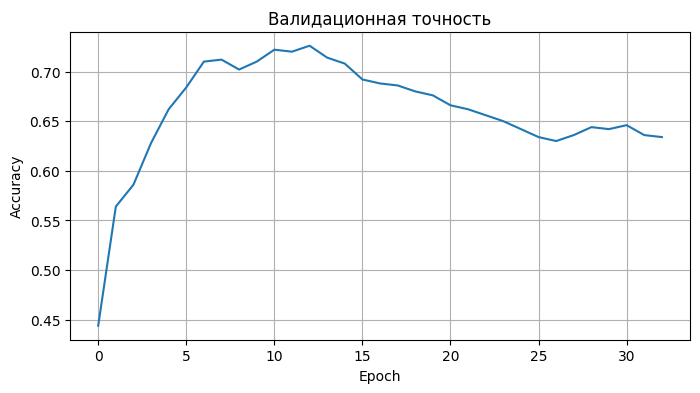

==================== Normalization: pair ====================
Epoch 000, Loss: 1.9660, Val Acc: 0.3780
Epoch 010, Loss: 1.4446, Val Acc: 0.7340
Epoch 020, Loss: 1.1753, Val Acc: 0.7160
Early stopping at epoch 27


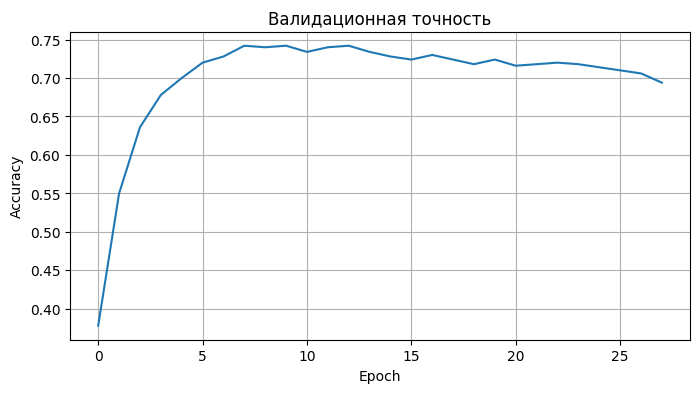

==================== Normalization: pair ====================
Epoch 000, Loss: 1.9528, Val Acc: 0.2180
Epoch 010, Loss: 1.8018, Val Acc: 0.5820
Epoch 020, Loss: 1.6888, Val Acc: 0.6500
Epoch 030, Loss: 1.5694, Val Acc: 0.6840
Epoch 040, Loss: 1.4723, Val Acc: 0.6900
Epoch 050, Loss: 1.3840, Val Acc: 0.6600
Early stopping at epoch 57


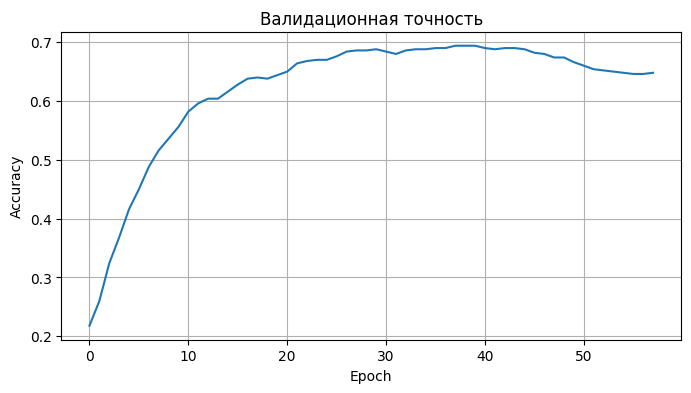

Normalization      Learning Rate    Train Acc    Val Acc    Test Acc    Over-smoothing
---------------  ---------------  -----------  ---------  ----------  ----------------
none                       0.01      1             0.772       0.797         24.6342
none                       0.005     0.992857      0.78        0.805          4.17109
none                       0.001     0.985714      0.776       0.797          1.43705
batch                      0.01      1             0.736       0.777          3.26943
batch                      0.005     0.992857      0.638       0.666          2.01469
batch                      0.001     0.978571      0.748       0.754          0.762075
layer                      0.01      0.992857      0.754       0.777          8.56489
layer                      0.005     1             0.766       0.809         12.0399
layer                      0.001     1             0.738       0.78          10.5714
pair                       0.01      0.964286      0.6

In [9]:
results = []

for normalization in ['none', 'batch', 'layer', 'pair']:
    for lr in [0.01, 0.005, 0.001]:
        print("=" * 20 + f" Normalization: {normalization} " + "=" * 20)
        model = GCN(in_channels=dataset.num_features, out_channels=dataset.num_classes, normalization=normalization).to(device)
        train_acc, val_acc, test_acc, os = train_and_evaluate_node_model(model, data, lr=lr)
        results.append([normalization, lr, train_acc, val_acc, test_acc, os])

print(tabulate(results, headers=["Normalization", "Learning Rate", "Train Acc", "Val Acc", "Test Acc", "Over-smoothing"]))

> **BatchNorm** незначительно ухудшил качество на валидации и тесте, однако довольно сильно повысил стабильность. Показал высокую чувствительность к выбору learning rate, но высокое снижение _over-smoothing_-а.
>
> **LayerNorm** показал результаты близкие к базовому варианту, но с гораздо больше стабильностью на поздних этапах при любых _lr_ (в сравнении с BatchNorm). Стоит отметить, что _over-smoothing_ повысился при малых learning rate.
>
> **PairNorm** показал самую сильную способность к переобучению, что привело к самому плохому результату на валидации и тесте. Он также оказался довольно чувствителен к выбору learning rate, однако имеет наилучшее снижение _over-smoothing_-а среди всех вариантов.

> Какой вариант нормализации показал себя лучше всего для данной задачи?
>
> Наиболее эффективной оказалась не использованная нормализация вовсе, однако **LayerNorm** значительно улучшил устойчивость к переобучению на поздних этапах. Также этот метод показал одну из лучших скоростей сходимости, хотя и при больших значениях learning rate увеличивал _over-smoothing_.

### 1.4 Residual Connections (Skip Connections)

Добавление остаточных связей:

$
h_v^{(k+1)} = h_v^{(k)} + \text{GCNLayer}(h_v^{(k)})
$

— улучшает распространение градиентов и сохраняет индивидуальность узлов.

Задание:
1. Добавьте residual connection между слоями GCN.
2. Проверьте, можно ли теперь использовать более глубокую модель (3–4 слоя)

**Вопросы:**

* Улучшается ли обучение GCN?
* Перестаёт ли сеть «слишком усреднять» узлы?



==================== Depth: 2 ====================
Epoch 000, Loss: 1.9510, Val Acc: 0.5240
Epoch 010, Loss: 0.4226, Val Acc: 0.7840
Epoch 020, Loss: 0.1008, Val Acc: 0.7740
Epoch 030, Loss: 0.0447, Val Acc: 0.7760
Early stopping at epoch 31


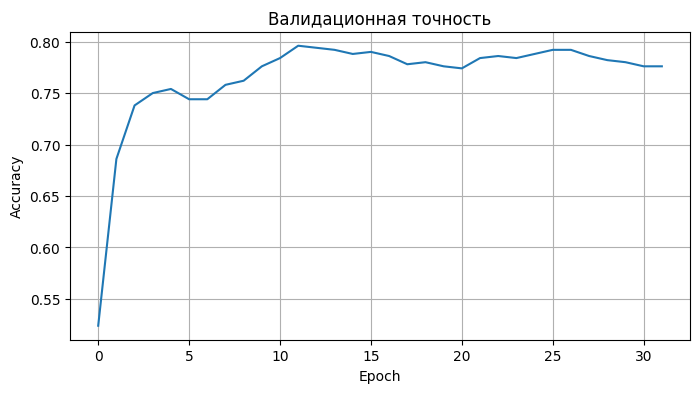

==================== Depth: 3 ====================
Epoch 000, Loss: 1.9472, Val Acc: 0.4900
Epoch 010, Loss: 0.3810, Val Acc: 0.7760
Epoch 020, Loss: 0.0870, Val Acc: 0.7700
Epoch 030, Loss: 0.0662, Val Acc: 0.7600
Epoch 040, Loss: 0.0290, Val Acc: 0.7740
Early stopping at epoch 46


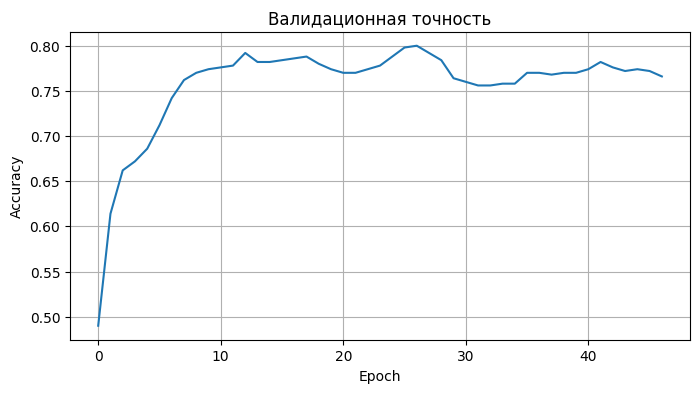

==================== Depth: 4 ====================
Epoch 000, Loss: 1.9661, Val Acc: 0.2320
Epoch 010, Loss: 0.3244, Val Acc: 0.7940
Epoch 020, Loss: 0.0773, Val Acc: 0.7620
Early stopping at epoch 29


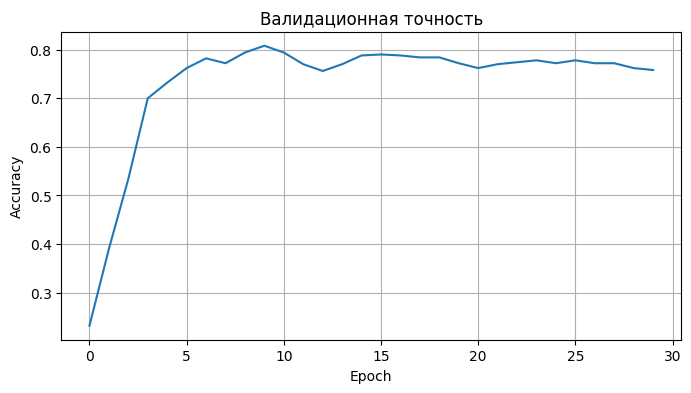

  Depth with Skip Connections    Train Acc    Val Acc    Test Acc    Over-smoothing
-----------------------------  -----------  ---------  ----------  ----------------
                            2     0.985714      0.776       0.809           1.75181
                            3     0.992857      0.766       0.799          27.0236
                            4     0.978571      0.758       0.797           5.95556


In [10]:
results = []

for depth in [2, 3, 4]:
    print("=" * 20 + f" Depth: {depth} " + "=" * 20)
    hidden_channels = [32] * (depth - 1)
    model = GCN(in_channels=dataset.num_features, out_channels=dataset.num_classes, hidden_channels=hidden_channels, use_skip_connections=True).to(device)
    train_acc, val_acc, test_acc, os = train_and_evaluate_node_model(model, data)
    results.append([depth, train_acc, val_acc, test_acc, os])

print(tabulate(results, headers=["Depth with Skip Connections", "Train Acc", "Val Acc", "Test Acc", "Over-smoothing"]))

> Улучшается ли обучение GCN?
>
> Пропускные связи помогают: без них глубокую модель обучать было бы гораздо сложнее из-за проблемы затухания градиентов.
> С пропускными связями удалось использовать 4 слоя с несущественной просадкой качества, тогда как без них глубокие модели быстро становились непригодными.
> Однако оптимальная глубина остаётся на уровне 2 слоёв.
>
> Пропускные связи сохраняют информацию из ранних слоёв и облегчают обучение, что помогает с проблемой усреднения на малом числе слоёв, но сравним с LayerNorm.

### 1.5 DropEdge

DropEdge случайно удаляет часть рёбер:

$
\tilde{E} = \text{Dropout}(E)
$

Этот метод:
- уменьшает степень узлов,
- снижает oversmoothing,
- действует как регуляризация.

Задание:
1. Реализуйте DropEdge: случайно удаляйте `p` рёбер на каждой эпохе.
2. Обучите GCN на этом изменённом графе.
3. Постройте метрики качества.

**Вопросы:**
- Улучшается ли устойчивость сети к переобучению?
- Какой процент удаляемых рёбер оптимален?

==================== DropEdge p=0.0 ====================
Epoch 000, Loss: 1.9516, Val Acc: 0.3140


Epoch 010, Loss: 0.6330, Val Acc: 0.7540
Epoch 020, Loss: 0.1743, Val Acc: 0.7760
Epoch 030, Loss: 0.0596, Val Acc: 0.7380
Early stopping at epoch 32


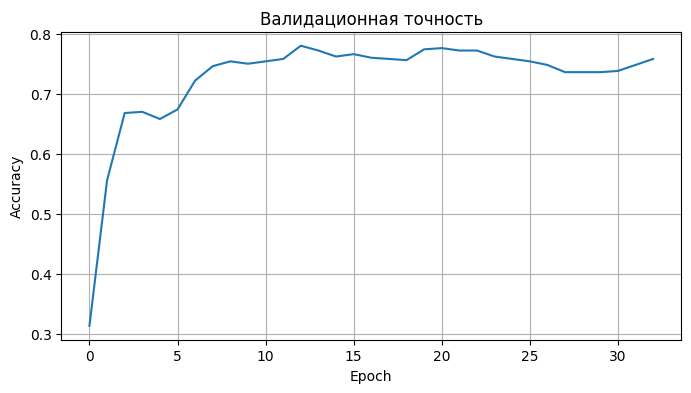

==================== DropEdge p=0.2 ====================
Epoch 000, Loss: 1.9490, Val Acc: 0.3860
Epoch 010, Loss: 0.7263, Val Acc: 0.7820
Epoch 020, Loss: 0.1451, Val Acc: 0.7760
Epoch 030, Loss: 0.1006, Val Acc: 0.7980
Epoch 040, Loss: 0.0445, Val Acc: 0.7720
Early stopping at epoch 49


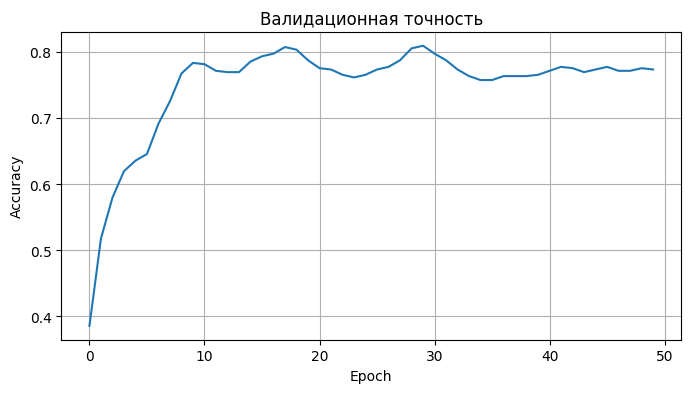

==================== DropEdge p=0.5 ====================
Epoch 000, Loss: 1.9552, Val Acc: 0.4720
Epoch 010, Loss: 0.8359, Val Acc: 0.7780
Epoch 020, Loss: 0.1701, Val Acc: 0.7620
Epoch 030, Loss: 0.0639, Val Acc: 0.7580
Early stopping at epoch 35


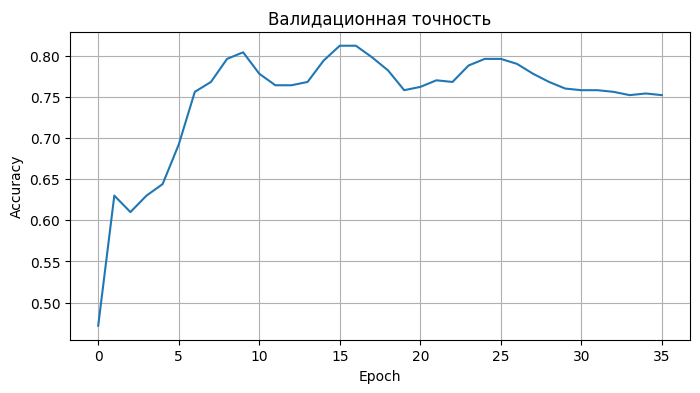

  DropEdge p    Train Acc    Val Acc    Test Acc
------------  -----------  ---------  ----------
         0       0.985714      0.758       0.801
         0.2     1             0.774       0.804
         0.5     0.985714      0.752       0.811


In [11]:
results = []

for dropedge_p in [0.0, 0.2, 0.5]:
    print("=" * 20 + f" DropEdge p={dropedge_p} " + "=" * 20)
    model = GCN(in_channels=dataset.num_features, out_channels=dataset.num_classes, edge_dropout=dropedge_p).to(device)
    train_acc, val_acc, test_acc, _ = train_and_evaluate_node_model(model, data)
    results.append([dropedge_p, train_acc, val_acc, test_acc])

print(tabulate(results, headers=["DropEdge p", "Train Acc", "Val Acc", "Test Acc"]))


> DropEdge показал себя эффективной техникой регуляризации. Валидационная точность в среднем вышла на на более высокий уровень.
>
> Оптимальный процент выпадения – примерно 20%. При 50% может быть потеря информации о структуре графа.
> Стоит отметить, что ориентирваться на test не стоит, т.к. его не используют для подбора гиперпараметров.

### 1.6 Исследование различных архитектур
Выберите 2 базовые архитектуры из списка: GraphSAGE, GAT(v2), GIN. Реализуйте их для задачи node classification и сравните полученные результаты.

Комментарий: при реализации, можно использовать наработки с предыдущих пунктов - добавлять разные виды модификаций (увеличивать число слоев / добавлять слои нормализации / residual conections...)

==================== Architecture: gcn ====================
Epoch 000, Loss: 1.9439, Val Acc: 0.3500
Epoch 010, Loss: 0.6676, Val Acc: 0.8020
Epoch 020, Loss: 0.1045, Val Acc: 0.7940
Epoch 030, Loss: 0.0641, Val Acc: 0.7920
Early stopping at epoch 32


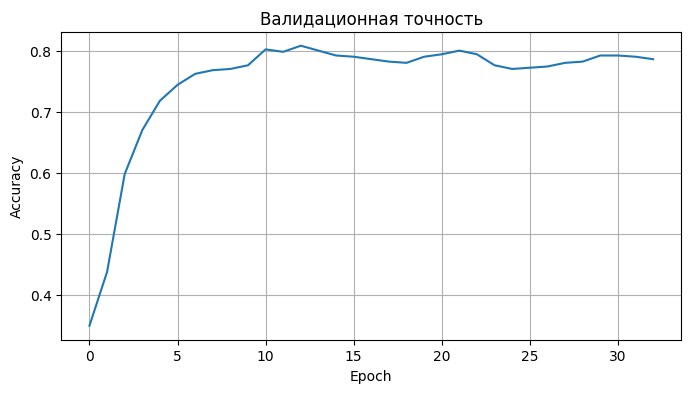

==================== Architecture: sage ====================
Epoch 000, Loss: 1.9546, Val Acc: 0.3200
Epoch 010, Loss: 0.6705, Val Acc: 0.7540
Epoch 020, Loss: 0.1288, Val Acc: 0.7620
Epoch 030, Loss: 0.0824, Val Acc: 0.7640
Early stopping at epoch 37


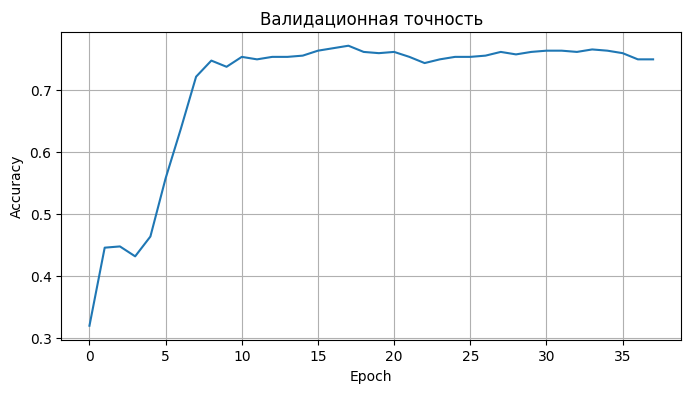

==================== Architecture: gatv2 ====================
Epoch 000, Loss: 1.9483, Val Acc: 0.0720
Epoch 010, Loss: 1.2019, Val Acc: 0.6480
Epoch 020, Loss: 0.2615, Val Acc: 0.7800
Epoch 030, Loss: 0.1393, Val Acc: 0.7800
Early stopping at epoch 34


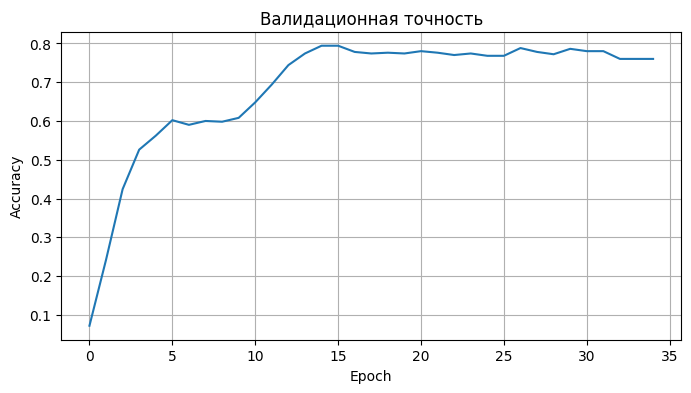

Architecture      Train Acc    Val Acc    Test Acc    Over-smoothing
--------------  -----------  ---------  ----------  ----------------
gcn                0.985714      0.786       0.818           4.46683
sage               1             0.75        0.801          18.4291
gatv2              0.992857      0.76        0.794           1.62189


In [12]:
results = []

for architecture in ['gcn', 'sage', 'gatv2']:
    print("=" * 20 + f" Architecture: {architecture} " + "=" * 20)
    model = GCN(in_channels=dataset.num_features, out_channels=dataset.num_classes, conv_type=architecture, gatv2_heads=4).to(device)
    train_acc, val_acc, test_acc, os = train_and_evaluate_node_model(model, data)
    results.append([architecture, train_acc, val_acc, test_acc, os])

print(tabulate(results, headers=["Architecture", "Train Acc", "Val Acc", "Test Acc", "Over-smoothing"]))

> **GCN** показал хороший базовый результат, стабилен и имеет небольшой over-smoothing.
>
> **GraphSAGE** немного уступает GCN на Cora, возможно, из-за выборки соседей. Его преимущество проявляется на индуктивных задачах и больших графах.
>
> **GATv2** оказался лучшим по over-smoothing-у. Механизм attention позволяет модели лучше взвешивать важность соседей для каждого узла. Это особенно полезно для узлов, связанных с непохожими соседями. Также Attention-механизм интерпретируем, что позволяет увидеть, на какие соседей обращает внимание модель.

# Часть 2. Link Prediction

### 2.1 Реализация MLP-декодера

Вместо dot-product декодера:

$
s_{uv} = z_u^\top z_v
$

реализуйте:

$
s_{uv} = \mathrm{MLP}([z_u ,||, z_v])
$

Сравните качество (AUC, AP) с dot-product.

In [13]:
# Применим RandomLinkSplit
transform = RandomLinkSplit(
    is_undirected=True,              # Граф без направлений
    split_labels=True,               # Метки (0/1) будут созданы
    add_negative_train_samples=True  # Добавить отрицательные примеры в train
)

train_data, val_data, test_data = transform(data)
train_data, val_data = train_data.to(device), val_data.to(device)

def train_and_evaluate_link_model(model, decoder, train_data=train_data, val_data=val_data, test_data=test_data):
    all_parameters = list(model.parameters()) + list(decoder.parameters())
    optimizer = torch.optim.Adam(all_parameters, lr=0.01, weight_decay=5e-4)

    train_losses, val_losses, val_acc = train_link_prediction(model, decoder, train_data, val_data, optimizer, epochs=200)
    # Оценка на тесте
    test_acc, test_ap = evaluate_link_prediction(model, decoder, test_data)

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel("Epoch")
    plt.title("Loss during Link Prediction Training")
    plt.legend()
    plt.grid(True)
    plt.show()

    return val_acc[-1], test_acc, test_ap

In [14]:
# Определим GCN Encoder
class GCNEncoder(torch.nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            dropout=0.5,
            conv_type: Literal['gcn', 'sage', 'gatv2', 'gin']='gcn',
            gatv2_heads: Optional[int]=None,
        ):
        super().__init__()

        assert conv_type != 'gatv2' or gatv2_heads is not None, "For GATv2 conv_type, gatv2_heads must be specified."

        conv_factory = {
            'gcn': lambda in_, out_: GCNConv(in_, out_),
            'sage': lambda in_, out_: SAGEConv(in_, out_),
            'gatv2': lambda in_, out_: GATv2Conv(in_, out_, heads=gatv2_heads, concat=False),
            # 'gin': lambda in_, out_: GINConv(), # TODO: реализовать GINConv с MLP
        }

        self.conv1 = conv_factory[conv_type](in_channels, 2 * out_channels)
        self.conv2 = conv_factory[conv_type](2 * out_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [15]:
class DotProductDecoder(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()

    def forward(self, z, pos_edge_index, neg_edge_index):
        pos_score = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
        neg_score = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
        scores = torch.cat([pos_score, neg_score], dim=0)

        labels = torch.cat([
            torch.ones(pos_score.size(0)),
            torch.zeros(neg_score.size(0))
        ]).to(scores.device)

        return labels, scores
    
class MLPDecoder(torch.nn.Module):
    def __init__(
            self,
            in_channels,
            hidden_channels=[32, 16],
            normalization: Literal['batch', 'layer', 'none', 'pair']='none',
            dropout=0.0,
            use_skip_connections=False,
        ):
        super().__init__()

        self.dropout = dropout
        self.use_skip_connections = use_skip_connections
        
        self.feedforward_layers = torch.nn.ModuleList()
        layer_in_channels = 2 * in_channels  # конкатенация эмбеддингов двух узлов
        for hidden_channel in hidden_channels:
            if use_skip_connections and layer_in_channels != hidden_channel:
                print(f"Warning: Skip connections wouldn't be used for layer with in_channels={layer_in_channels} and out_channels={hidden_channel}")

            self.feedforward_layers.append(torch.nn.Linear(layer_in_channels, hidden_channel))
            layer_in_channels = hidden_channel
        self.feedforward_layers.append(torch.nn.Linear(layer_in_channels, 1))

        normalization_factory = {
            'batch': lambda ch: torch.nn.BatchNorm1d(ch),
            'layer': lambda ch: torch.nn.LayerNorm(ch),
            'pair': lambda ch: PairNorm(),
            'none': lambda ch: torch.nn.Identity(),
        }
        self.normalization_layers = torch.nn.ModuleList()
        for hidden_channel in hidden_channels:
            self.normalization_layers.append(normalization_factory[normalization](hidden_channel))

    def forward(self, z, pos_edge_index, neg_edge_index):
        def decode(edge_index):
            src, dst = edge_index
            edge_features = torch.cat([z[src], z[dst]], dim=1)
            
            x = edge_features
            
            for i, layer in enumerate(self.feedforward_layers[:-1]):
                skip_x = x  # для пропуска

                x = F.relu(layer(x))
                x = self.normalization_layers[i](x)
                x = F.dropout(x, p=self.dropout, training=self.training)
                
                if self.use_skip_connections and skip_x.size() == x.size():
                    x = x + skip_x
            
            x = self.feedforward_layers[-1](x).squeeze()
            
            return x

        pos_score = decode(pos_edge_index)
        neg_score = decode(neg_edge_index)
        scores = torch.cat([pos_score, neg_score], dim=0)

        labels = torch.cat([
            torch.ones(pos_score.size(0)),
            torch.zeros(neg_score.size(0))
        ]).to(scores.device)

        return labels, scores

==================== Decoder: DotProductDecoder ====================
Epoch 000, Train Loss: 0.6609, Val Loss: 0.3858, Val AUC: 0.6381
Epoch 001, Train Loss: 0.3223, Val Loss: 0.6345, Val AUC: 0.6165
Epoch 002, Train Loss: 0.4323, Val Loss: 0.5286, Val AUC: 0.6238
Epoch 003, Train Loss: 0.3614, Val Loss: 0.3639, Val AUC: 0.6479
Epoch 004, Train Loss: 0.2598, Val Loss: 0.3498, Val AUC: 0.6893
Epoch 005, Train Loss: 0.2631, Val Loss: 0.3460, Val AUC: 0.6907
Epoch 006, Train Loss: 0.2583, Val Loss: 0.3477, Val AUC: 0.6756
Epoch 007, Train Loss: 0.2568, Val Loss: 0.3716, Val AUC: 0.6736
Epoch 008, Train Loss: 0.2569, Val Loss: 0.3622, Val AUC: 0.6825
Epoch 009, Train Loss: 0.2552, Val Loss: 0.3352, Val AUC: 0.7119
Epoch 010, Train Loss: 0.2318, Val Loss: 0.3277, Val AUC: 0.7468
Epoch 011, Train Loss: 0.2278, Val Loss: 0.3200, Val AUC: 0.7596
Epoch 012, Train Loss: 0.2088, Val Loss: 0.3128, Val AUC: 0.7635
Epoch 013, Train Loss: 0.1943, Val Loss: 0.3115, Val AUC: 0.7646
Epoch 014, Train Loss

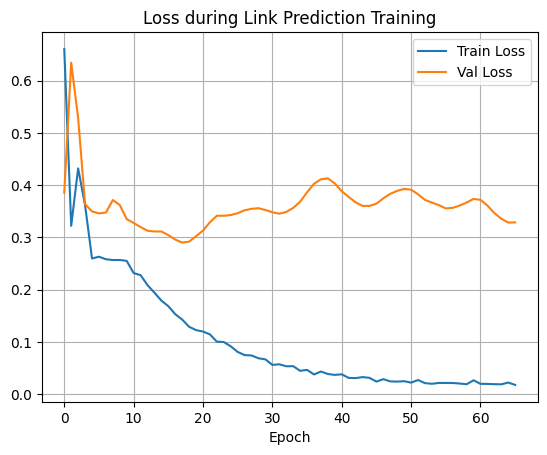

==================== Decoder: MLPDecoder ====================
Epoch 000, Train Loss: 0.6246, Val Loss: 0.4861, Val AUC: 0.5577
Epoch 001, Train Loss: 0.6030, Val Loss: 0.3788, Val AUC: 0.5588
Epoch 002, Train Loss: 0.5802, Val Loss: 0.3632, Val AUC: 0.6117
Epoch 003, Train Loss: 0.5393, Val Loss: 0.4770, Val AUC: 0.6269
Epoch 004, Train Loss: 0.4831, Val Loss: 0.7940, Val AUC: 0.6297
Epoch 005, Train Loss: 0.4093, Val Loss: 1.3528, Val AUC: 0.6301
Epoch 006, Train Loss: 0.3319, Val Loss: 2.2170, Val AUC: 0.6307
Epoch 007, Train Loss: 0.2891, Val Loss: 3.2841, Val AUC: 0.6307
Epoch 008, Train Loss: 0.3101, Val Loss: 3.9282, Val AUC: 0.6326
Epoch 009, Train Loss: 0.3505, Val Loss: 3.9408, Val AUC: 0.6333
Epoch 010, Train Loss: 0.3471, Val Loss: 3.5764, Val AUC: 0.6341
Epoch 011, Train Loss: 0.3194, Val Loss: 3.0772, Val AUC: 0.6347
Epoch 012, Train Loss: 0.2961, Val Loss: 2.6001, Val AUC: 0.6351
Epoch 013, Train Loss: 0.2856, Val Loss: 2.2310, Val AUC: 0.6335
Epoch 014, Train Loss: 0.292

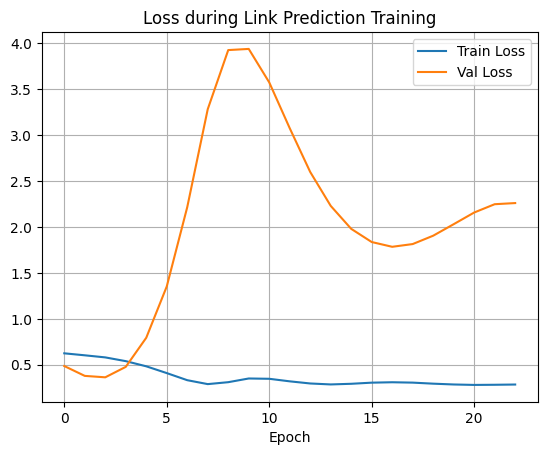

Decoder              Val Acc    Test Acc    Test AP
-----------------  ---------  ----------  ---------
DotProductDecoder   0.862812    0.874904   0.984269
MLPDecoder          0.631404    0.681616   0.956145


In [20]:
results = []

for decoder_class in [DotProductDecoder, MLPDecoder]:
    print("=" * 20 + f" Decoder: {decoder_class.__name__} " + "=" * 20)
    encoder = GCNEncoder(in_channels=dataset.num_features, out_channels=16).to(device)
    decoder = decoder_class(in_channels=16).to(device)
    val_acc, test_acc, test_ap = train_and_evaluate_link_model(encoder, decoder, train_data, val_data, test_data)
    results.append([decoder_class.__name__, val_acc, test_acc, test_ap])
    
print(tabulate(results, headers=["Decoder", "Val Acc", "Test Acc", "Test AP"]))

> Несмотря на то, что MLP может учиться более сложным закономерностям взаимодействия между эмбеддингами двух узлов: нелинейные комбинации, скрытые признаки сходства, MLP-декодер не превосходит dot-product, который рассматривает только скалярное произведение эмбеддингов – это очень ограниченная функция для оценки сходства.

### 2.2 Эксперимент с negative sampling ratio

Попробуйте соотношения:

```
1:1, 1:2, 1:5, 1:10
```

Постройте таблицу для AUC и AP. Опишите полученные результаты


==================== Negative Sampling Ratio: 1.0 ====================
Epoch 000, Train Loss: 0.6955, Val Loss: 0.7352, Val AUC: 0.6601
Epoch 001, Train Loss: 0.6887, Val Loss: 1.6240, Val AUC: 0.6619
Epoch 002, Train Loss: 0.6849, Val Loss: 2.0838, Val AUC: 0.6624
Epoch 003, Train Loss: 0.6836, Val Loss: 1.3826, Val AUC: 0.6615
Epoch 004, Train Loss: 0.6778, Val Loss: 1.1520, Val AUC: 0.6595
Epoch 005, Train Loss: 0.6754, Val Loss: 1.3024, Val AUC: 0.6593
Epoch 006, Train Loss: 0.6680, Val Loss: 1.6074, Val AUC: 0.6595
Epoch 007, Train Loss: 0.6631, Val Loss: 1.1220, Val AUC: 0.6562
Epoch 008, Train Loss: 0.6544, Val Loss: 0.7650, Val AUC: 0.6481
Epoch 009, Train Loss: 0.6500, Val Loss: 0.8238, Val AUC: 0.6530
Epoch 010, Train Loss: 0.6352, Val Loss: 0.8197, Val AUC: 0.6545
Epoch 011, Train Loss: 0.6280, Val Loss: 0.6689, Val AUC: 0.6474
Epoch 012, Train Loss: 0.6303, Val Loss: 0.6860, Val AUC: 0.6543
Early stopping at epoch 12 (best AUC = 0.6624)
Loading the best model weights...


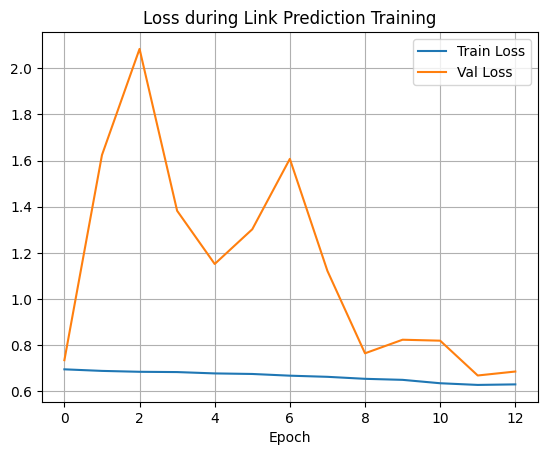

==================== Negative Sampling Ratio: 0.5 ====================
Epoch 000, Train Loss: 0.7501, Val Loss: 0.7351, Val AUC: 0.5814
Epoch 001, Train Loss: 0.7329, Val Loss: 1.4673, Val AUC: 0.6724
Epoch 002, Train Loss: 0.7070, Val Loss: 3.5934, Val AUC: 0.6701
Epoch 003, Train Loss: 0.6720, Val Loss: 8.3729, Val AUC: 0.6691
Epoch 004, Train Loss: 0.6239, Val Loss: 17.5568, Val AUC: 0.6689
Epoch 005, Train Loss: 0.6101, Val Loss: 23.1094, Val AUC: 0.6703
Epoch 006, Train Loss: 0.6374, Val Loss: 19.6755, Val AUC: 0.6710
Epoch 007, Train Loss: 0.6176, Val Loss: 14.5188, Val AUC: 0.6715
Epoch 008, Train Loss: 0.6030, Val Loss: 10.8091, Val AUC: 0.6724
Epoch 009, Train Loss: 0.6090, Val Loss: 8.8604, Val AUC: 0.6739
Epoch 010, Train Loss: 0.6164, Val Loss: 8.2046, Val AUC: 0.6753
Epoch 011, Train Loss: 0.6189, Val Loss: 8.5153, Val AUC: 0.6762
Epoch 012, Train Loss: 0.6131, Val Loss: 9.6381, Val AUC: 0.6767
Epoch 013, Train Loss: 0.6057, Val Loss: 11.3998, Val AUC: 0.6771
Epoch 014, Tr

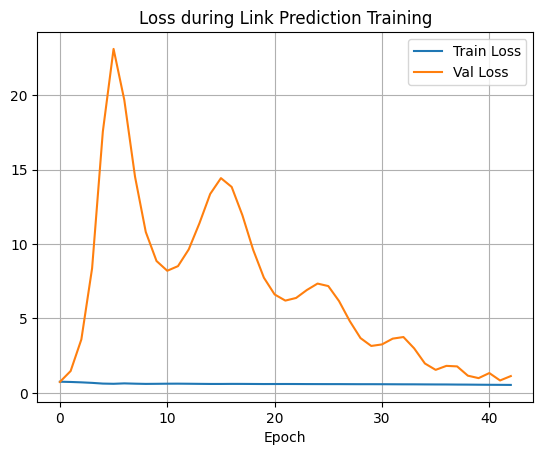

==================== Negative Sampling Ratio: 0.2 ====================
Epoch 000, Train Loss: 0.6644, Val Loss: 0.5574, Val AUC: 0.6597
Epoch 001, Train Loss: 0.6523, Val Loss: 0.5716, Val AUC: 0.7019
Epoch 002, Train Loss: 0.6118, Val Loss: 1.5595, Val AUC: 0.6995
Epoch 003, Train Loss: 0.5286, Val Loss: 4.1443, Val AUC: 0.7014
Epoch 004, Train Loss: 0.4327, Val Loss: 9.1340, Val AUC: 0.7023
Epoch 005, Train Loss: 0.4930, Val Loss: 9.0050, Val AUC: 0.7003
Epoch 006, Train Loss: 0.4821, Val Loss: 6.8416, Val AUC: 0.6979
Epoch 007, Train Loss: 0.4342, Val Loss: 4.8108, Val AUC: 0.6961
Epoch 008, Train Loss: 0.4242, Val Loss: 3.5849, Val AUC: 0.6916
Epoch 009, Train Loss: 0.4419, Val Loss: 3.0639, Val AUC: 0.6877
Epoch 010, Train Loss: 0.4542, Val Loss: 3.0367, Val AUC: 0.6844
Epoch 011, Train Loss: 0.4532, Val Loss: 3.3997, Val AUC: 0.6823
Epoch 012, Train Loss: 0.4412, Val Loss: 4.1163, Val AUC: 0.6816
Epoch 013, Train Loss: 0.4254, Val Loss: 5.1185, Val AUC: 0.6812
Epoch 014, Train Lo

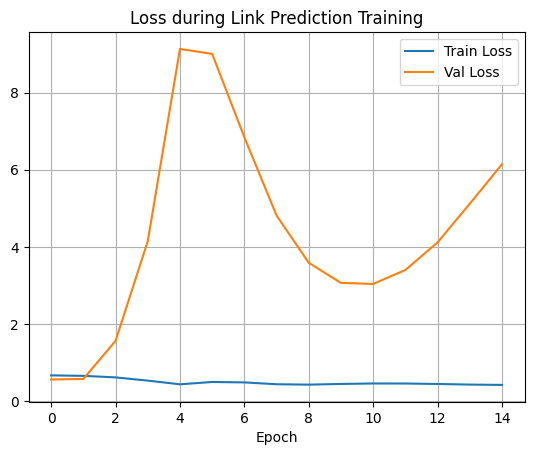

==================== Negative Sampling Ratio: 0.1 ====================
Epoch 000, Train Loss: 0.7672, Val Loss: 0.3982, Val AUC: 0.5817
Epoch 001, Train Loss: 0.7300, Val Loss: 0.6040, Val AUC: 0.6230
Epoch 002, Train Loss: 0.6649, Val Loss: 1.6196, Val AUC: 0.6299
Epoch 003, Train Loss: 0.5307, Val Loss: 3.6702, Val AUC: 0.6291
Epoch 004, Train Loss: 0.3560, Val Loss: 7.4776, Val AUC: 0.6294
Epoch 005, Train Loss: 0.2864, Val Loss: 11.6165, Val AUC: 0.6288
Epoch 006, Train Loss: 0.3722, Val Loss: 12.6589, Val AUC: 0.6284
Epoch 007, Train Loss: 0.3969, Val Loss: 11.4311, Val AUC: 0.6294
Epoch 008, Train Loss: 0.3490, Val Loss: 9.3233, Val AUC: 0.6298
Epoch 009, Train Loss: 0.3003, Val Loss: 7.2837, Val AUC: 0.6298
Epoch 010, Train Loss: 0.2822, Val Loss: 5.8209, Val AUC: 0.6306
Epoch 011, Train Loss: 0.3030, Val Loss: 5.0197, Val AUC: 0.6311
Epoch 012, Train Loss: 0.3248, Val Loss: 4.7570, Val AUC: 0.6321
Epoch 013, Train Loss: 0.3254, Val Loss: 4.9119, Val AUC: 0.6320
Epoch 014, Train

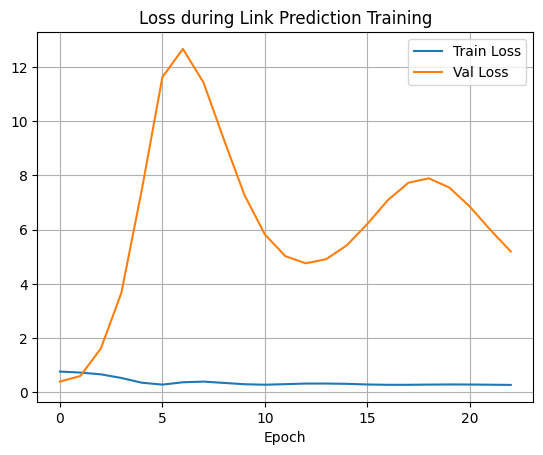

  Negative Sampling Ratio    Val Acc    Test Acc    Test AP
-------------------------  ---------  ----------  ---------
                      1     0.654329    0.659589   0.704922
                      0.5   0.67615     0.658879   0.817176
                      0.2   0.680726    0.676449   0.919959
                      0.1   0.62604     0.680045   0.955918


In [17]:
results = []

for negative_sampling_ratio in [1/1, 1/2, 1/5, 1/10]:
    print("=" * 20 + f" Negative Sampling Ratio: {negative_sampling_ratio} " + "=" * 20)

    transform = RandomLinkSplit(
        is_undirected=True,
        split_labels=True,
        add_negative_train_samples=True,
        neg_sampling_ratio=negative_sampling_ratio
    )
    train_data, val_data, test_data = transform(data)
    train_data, val_data = train_data.to(device), val_data.to(device)

    encoder = GCNEncoder(in_channels=dataset.num_features, out_channels=32).to(device)
    decoder = MLPDecoder(in_channels=32).to(device)
    val_acc, test_acc, test_ap = train_and_evaluate_link_model(encoder, decoder, train_data, val_data, test_data)
    results.append([negative_sampling_ratio, val_acc, test_acc, test_ap])

print(tabulate(results, headers=["Negative Sampling Ratio", "Val Acc", "Test Acc", "Test AP"]))

> **Оптимальное соотношение – 1:5** (одно положительное ребро на 5 отрицательных).
>
> При 1:1 модель недостаточно учится различать положительные и отрицательные примеры.
>
> При 1:2 и 1:5 качество хорошее, но 1:5 даёт лучший результат.
>
> При 1:10 слишком много отрицательных примеров, что может привести к дисбалансу классов и затруднить оптимизацию.

### 2.3 Оптизация текущей модели
Попробуйте улучшить текущую модель за счет использования следующих модификаций:
- добавление нормализации (BatchNorm / LayerNorm / PairNorm)
- Dropout
- residual connection

Опишите полученные результаты


==================== Norm: none, Dropout: 0.0, Skip: False ====================
Epoch 000, Train Loss: 0.7516, Val Loss: 0.3716, Val AUC: 0.6434
Epoch 001, Train Loss: 0.7185, Val Loss: 0.6288, Val AUC: 0.6293
Epoch 002, Train Loss: 0.6419, Val Loss: 1.8136, Val AUC: 0.6237
Epoch 003, Train Loss: 0.4873, Val Loss: 4.3457, Val AUC: 0.6255
Epoch 004, Train Loss: 0.3071, Val Loss: 9.0830, Val AUC: 0.6265
Epoch 005, Train Loss: 0.3360, Val Loss: 11.2168, Val AUC: 0.6270
Epoch 006, Train Loss: 0.4017, Val Loss: 10.2789, Val AUC: 0.6280
Epoch 007, Train Loss: 0.3625, Val Loss: 8.1320, Val AUC: 0.6271
Epoch 008, Train Loss: 0.3010, Val Loss: 6.0646, Val AUC: 0.6258
Epoch 009, Train Loss: 0.2810, Val Loss: 4.6831, Val AUC: 0.6261
Epoch 010, Train Loss: 0.3052, Val Loss: 4.0152, Val AUC: 0.6255
Early stopping at epoch 10 (best AUC = 0.6434)
Loading the best model weights...


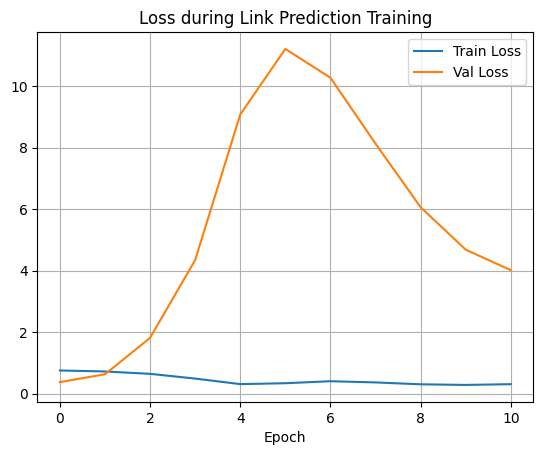

==================== Norm: none, Dropout: 0.0, Skip: True ====================
Epoch 000, Train Loss: 0.6286, Val Loss: 0.3718, Val AUC: 0.4818
Epoch 001, Train Loss: 0.5994, Val Loss: 0.3675, Val AUC: 0.5735
Epoch 002, Train Loss: 0.5706, Val Loss: 0.6245, Val AUC: 0.6163
Epoch 003, Train Loss: 0.5290, Val Loss: 1.2550, Val AUC: 0.6258
Epoch 004, Train Loss: 0.4583, Val Loss: 2.4999, Val AUC: 0.6305
Epoch 005, Train Loss: 0.3606, Val Loss: 4.8023, Val AUC: 0.6309
Epoch 006, Train Loss: 0.2902, Val Loss: 8.2485, Val AUC: 0.6296
Epoch 007, Train Loss: 0.3161, Val Loss: 9.8995, Val AUC: 0.6299
Epoch 008, Train Loss: 0.3525, Val Loss: 9.3753, Val AUC: 0.6307
Epoch 009, Train Loss: 0.3373, Val Loss: 7.8325, Val AUC: 0.6305
Epoch 010, Train Loss: 0.3057, Val Loss: 6.1414, Val AUC: 0.6296
Epoch 011, Train Loss: 0.2842, Val Loss: 4.8165, Val AUC: 0.6293
Epoch 012, Train Loss: 0.2897, Val Loss: 4.0019, Val AUC: 0.6293
Epoch 013, Train Loss: 0.3049, Val Loss: 3.6209, Val AUC: 0.6291
Epoch 014, 

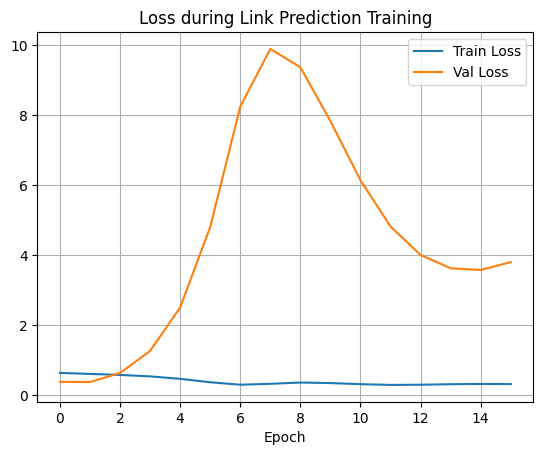

==================== Norm: none, Dropout: 0.5, Skip: False ====================
Epoch 000, Train Loss: 0.6232, Val Loss: 0.3766, Val AUC: 0.6314
Epoch 001, Train Loss: 0.5938, Val Loss: 0.6434, Val AUC: 0.6329
Epoch 002, Train Loss: 0.5319, Val Loss: 1.8420, Val AUC: 0.6301
Epoch 003, Train Loss: 0.4283, Val Loss: 4.4137, Val AUC: 0.6305
Epoch 004, Train Loss: 0.3539, Val Loss: 8.2717, Val AUC: 0.6300
Epoch 005, Train Loss: 0.3915, Val Loss: 9.0966, Val AUC: 0.6317
Epoch 006, Train Loss: 0.4119, Val Loss: 7.7630, Val AUC: 0.6322
Epoch 007, Train Loss: 0.3828, Val Loss: 5.8291, Val AUC: 0.6307
Epoch 008, Train Loss: 0.3378, Val Loss: 4.2183, Val AUC: 0.6297
Epoch 009, Train Loss: 0.3279, Val Loss: 3.2310, Val AUC: 0.6298
Epoch 010, Train Loss: 0.3470, Val Loss: 2.7481, Val AUC: 0.6316
Epoch 011, Train Loss: 0.3475, Val Loss: 2.6259, Val AUC: 0.6317
Early stopping at epoch 11 (best AUC = 0.6329)
Loading the best model weights...


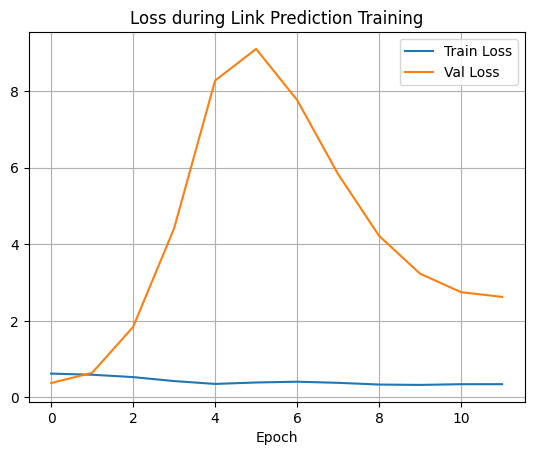

==================== Norm: none, Dropout: 0.5, Skip: True ====================
Epoch 000, Train Loss: 0.6044, Val Loss: 0.3800, Val AUC: 0.6127
Epoch 001, Train Loss: 0.5589, Val Loss: 0.7642, Val AUC: 0.6270
Epoch 002, Train Loss: 0.4650, Val Loss: 2.4316, Val AUC: 0.6278
Epoch 003, Train Loss: 0.3711, Val Loss: 5.5781, Val AUC: 0.6284
Epoch 004, Train Loss: 0.3882, Val Loss: 6.1806, Val AUC: 0.6298
Epoch 005, Train Loss: 0.3834, Val Loss: 5.0501, Val AUC: 0.6316
Epoch 006, Train Loss: 0.3547, Val Loss: 3.5933, Val AUC: 0.6327
Epoch 007, Train Loss: 0.3219, Val Loss: 2.5700, Val AUC: 0.6299
Epoch 008, Train Loss: 0.3349, Val Loss: 2.0433, Val AUC: 0.6290
Epoch 009, Train Loss: 0.3413, Val Loss: 1.8779, Val AUC: 0.6274
Epoch 010, Train Loss: 0.3451, Val Loss: 1.9626, Val AUC: 0.6264
Epoch 011, Train Loss: 0.3338, Val Loss: 2.2269, Val AUC: 0.6254
Epoch 012, Train Loss: 0.3264, Val Loss: 2.5638, Val AUC: 0.6261
Epoch 013, Train Loss: 0.3119, Val Loss: 2.8267, Val AUC: 0.6250
Epoch 014, 

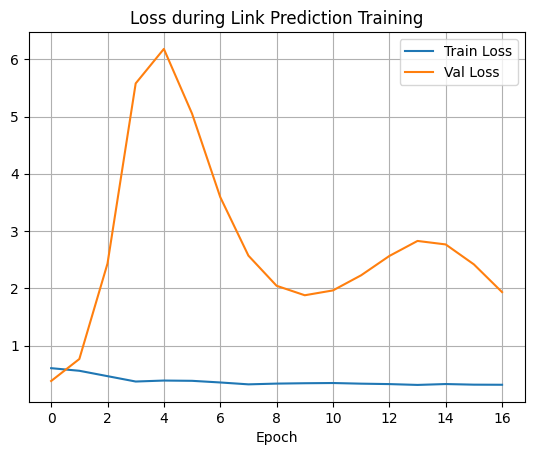

==================== Norm: batch, Dropout: 0.0, Skip: False ====================
Epoch 000, Train Loss: 0.6790, Val Loss: 0.5169, Val AUC: 0.5385
Epoch 001, Train Loss: 0.6496, Val Loss: 0.3977, Val AUC: 0.4760
Epoch 002, Train Loss: 0.6313, Val Loss: 0.3242, Val AUC: 0.4742
Epoch 003, Train Loss: 0.6188, Val Loss: 0.3018, Val AUC: 0.5261
Epoch 004, Train Loss: 0.6083, Val Loss: 0.3107, Val AUC: 0.5317
Epoch 005, Train Loss: 0.5983, Val Loss: 0.3350, Val AUC: 0.5132
Epoch 006, Train Loss: 0.5875, Val Loss: 0.3634, Val AUC: 0.4962
Epoch 007, Train Loss: 0.5766, Val Loss: 0.3914, Val AUC: 0.4882
Epoch 008, Train Loss: 0.5649, Val Loss: 0.4148, Val AUC: 0.4754
Epoch 009, Train Loss: 0.5531, Val Loss: 0.4298, Val AUC: 0.4598
Epoch 010, Train Loss: 0.5402, Val Loss: 0.4400, Val AUC: 0.4552
Early stopping at epoch 10 (best AUC = 0.5385)
Loading the best model weights...


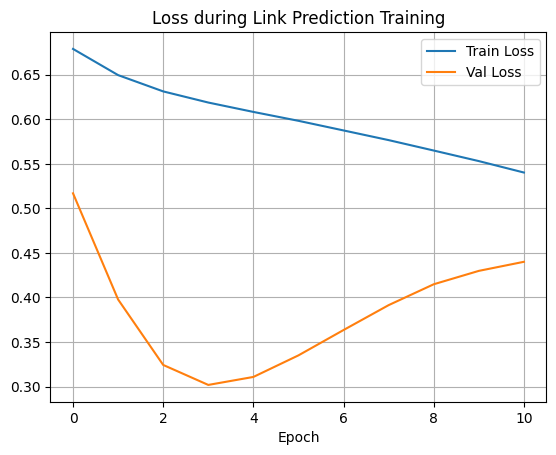

==================== Norm: batch, Dropout: 0.0, Skip: True ====================
Epoch 000, Train Loss: 0.7135, Val Loss: 0.5193, Val AUC: 0.5339
Epoch 001, Train Loss: 0.6787, Val Loss: 0.3850, Val AUC: 0.5173
Epoch 002, Train Loss: 0.6582, Val Loss: 0.3505, Val AUC: 0.4791
Epoch 003, Train Loss: 0.6444, Val Loss: 0.3845, Val AUC: 0.4911
Epoch 004, Train Loss: 0.6339, Val Loss: 0.4630, Val AUC: 0.4881
Epoch 005, Train Loss: 0.6249, Val Loss: 0.5582, Val AUC: 0.5147
Epoch 006, Train Loss: 0.6149, Val Loss: 0.6547, Val AUC: 0.5436
Epoch 007, Train Loss: 0.6050, Val Loss: 0.7457, Val AUC: 0.5766
Epoch 008, Train Loss: 0.5943, Val Loss: 0.8283, Val AUC: 0.5933
Epoch 009, Train Loss: 0.5829, Val Loss: 0.8975, Val AUC: 0.5913
Epoch 010, Train Loss: 0.5705, Val Loss: 0.9520, Val AUC: 0.5721
Epoch 011, Train Loss: 0.5579, Val Loss: 0.9926, Val AUC: 0.5588
Epoch 012, Train Loss: 0.5444, Val Loss: 1.0195, Val AUC: 0.5530
Epoch 013, Train Loss: 0.5307, Val Loss: 1.0322, Val AUC: 0.5493
Epoch 014,

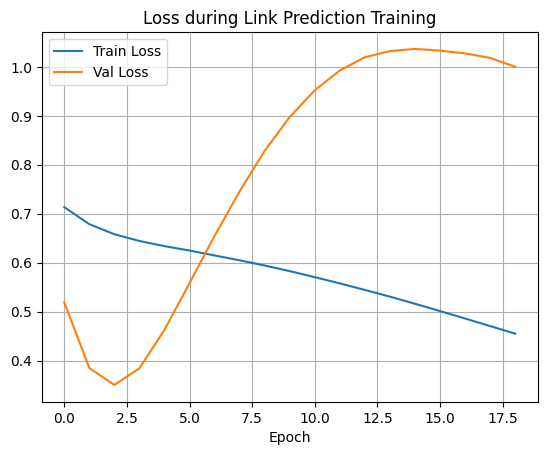

==================== Norm: batch, Dropout: 0.5, Skip: False ====================
Epoch 000, Train Loss: 0.7355, Val Loss: 0.5895, Val AUC: 0.4677
Epoch 001, Train Loss: 0.7158, Val Loss: 0.5247, Val AUC: 0.4587
Epoch 002, Train Loss: 0.6898, Val Loss: 0.4625, Val AUC: 0.4803
Epoch 003, Train Loss: 0.6755, Val Loss: 0.4145, Val AUC: 0.5191
Epoch 004, Train Loss: 0.6630, Val Loss: 0.3889, Val AUC: 0.5288
Epoch 005, Train Loss: 0.6571, Val Loss: 0.3795, Val AUC: 0.5263
Epoch 006, Train Loss: 0.6472, Val Loss: 0.3818, Val AUC: 0.5289
Epoch 007, Train Loss: 0.6390, Val Loss: 0.3934, Val AUC: 0.5262
Epoch 008, Train Loss: 0.6312, Val Loss: 0.4159, Val AUC: 0.5160
Epoch 009, Train Loss: 0.6226, Val Loss: 0.4431, Val AUC: 0.5041
Epoch 010, Train Loss: 0.6159, Val Loss: 0.4725, Val AUC: 0.4999
Epoch 011, Train Loss: 0.6099, Val Loss: 0.5011, Val AUC: 0.5039
Epoch 012, Train Loss: 0.5983, Val Loss: 0.5304, Val AUC: 0.4936
Epoch 013, Train Loss: 0.5924, Val Loss: 0.5581, Val AUC: 0.4849
Epoch 014

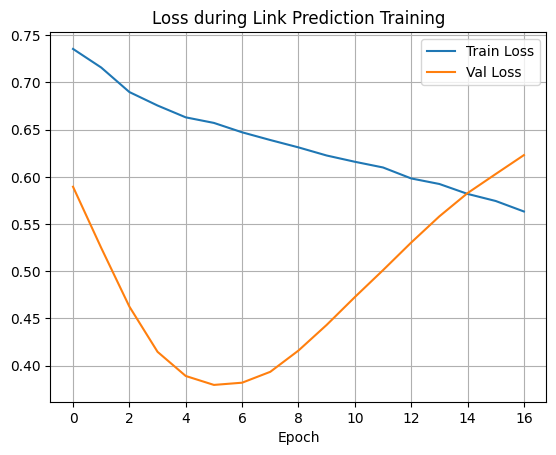

==================== Norm: batch, Dropout: 0.5, Skip: True ====================
Epoch 000, Train Loss: 0.8099, Val Loss: 0.5545, Val AUC: 0.5353
Epoch 001, Train Loss: 0.7766, Val Loss: 0.4455, Val AUC: 0.5406
Epoch 002, Train Loss: 0.7677, Val Loss: 0.3604, Val AUC: 0.5399
Epoch 003, Train Loss: 0.7511, Val Loss: 0.3097, Val AUC: 0.4843
Epoch 004, Train Loss: 0.7304, Val Loss: 0.3015, Val AUC: 0.4523
Epoch 005, Train Loss: 0.7129, Val Loss: 0.3264, Val AUC: 0.4413
Epoch 006, Train Loss: 0.6992, Val Loss: 0.3671, Val AUC: 0.4470
Epoch 007, Train Loss: 0.6950, Val Loss: 0.4272, Val AUC: 0.4657
Epoch 008, Train Loss: 0.6834, Val Loss: 0.4938, Val AUC: 0.4672
Epoch 009, Train Loss: 0.6791, Val Loss: 0.5618, Val AUC: 0.4665
Epoch 010, Train Loss: 0.6672, Val Loss: 0.6306, Val AUC: 0.4777
Epoch 011, Train Loss: 0.6490, Val Loss: 0.7081, Val AUC: 0.4662
Early stopping at epoch 11 (best AUC = 0.5406)
Loading the best model weights...


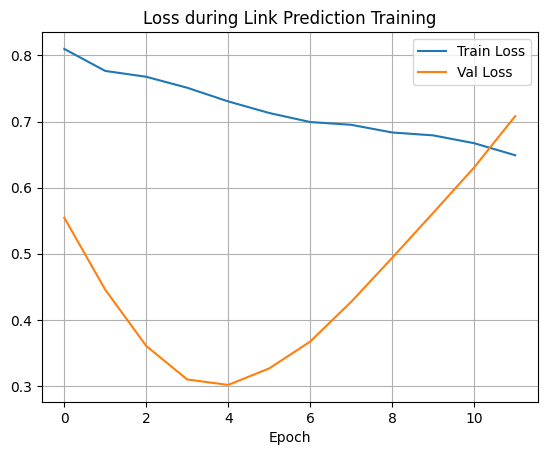

==================== Norm: layer, Dropout: 0.0, Skip: False ====================
Epoch 000, Train Loss: 1.1247, Val Loss: 0.3611, Val AUC: 0.5029
Epoch 001, Train Loss: 0.4385, Val Loss: 0.6286, Val AUC: 0.4527
Epoch 002, Train Loss: 0.3451, Val Loss: 1.2389, Val AUC: 0.4707
Epoch 003, Train Loss: 0.3177, Val Loss: 2.0204, Val AUC: 0.4174
Epoch 004, Train Loss: 0.3065, Val Loss: 2.9231, Val AUC: 0.4948
Epoch 005, Train Loss: 0.3040, Val Loss: 3.9082, Val AUC: 0.5138
Epoch 006, Train Loss: 0.3041, Val Loss: 4.9429, Val AUC: 0.5228
Epoch 007, Train Loss: 0.3042, Val Loss: 6.0002, Val AUC: 0.5261
Epoch 008, Train Loss: 0.3043, Val Loss: 7.0579, Val AUC: 0.5269
Epoch 009, Train Loss: 0.3044, Val Loss: 8.0978, Val AUC: 0.5251
Epoch 010, Train Loss: 0.3044, Val Loss: 9.1046, Val AUC: 0.5242
Epoch 011, Train Loss: 0.3041, Val Loss: 10.0666, Val AUC: 0.5244
Epoch 012, Train Loss: 0.3043, Val Loss: 10.9759, Val AUC: 0.5251
Epoch 013, Train Loss: 0.3042, Val Loss: 11.8234, Val AUC: 0.5261
Epoch 

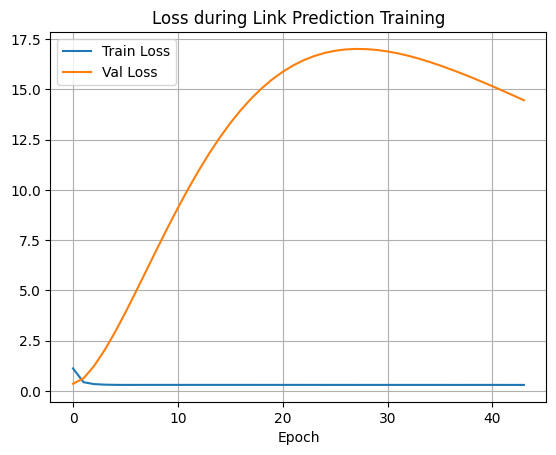

==================== Norm: layer, Dropout: 0.0, Skip: True ====================
Epoch 000, Train Loss: 0.7474, Val Loss: 0.3449, Val AUC: 0.5736
Epoch 001, Train Loss: 0.3279, Val Loss: 0.8372, Val AUC: 0.4819
Epoch 002, Train Loss: 0.3055, Val Loss: 1.6891, Val AUC: 0.4301
Epoch 003, Train Loss: 0.3054, Val Loss: 2.7474, Val AUC: 0.4123
Epoch 004, Train Loss: 0.3060, Val Loss: 3.9514, Val AUC: 0.4138
Epoch 005, Train Loss: 0.3047, Val Loss: 5.2516, Val AUC: 0.4247
Epoch 006, Train Loss: 0.3049, Val Loss: 6.6074, Val AUC: 0.4238
Epoch 007, Train Loss: 0.3050, Val Loss: 7.9843, Val AUC: 0.4194
Epoch 008, Train Loss: 0.3047, Val Loss: 9.3535, Val AUC: 0.4019
Epoch 009, Train Loss: 0.3048, Val Loss: 10.6929, Val AUC: 0.3815
Epoch 010, Train Loss: 0.3046, Val Loss: 11.9847, Val AUC: 0.4182
Early stopping at epoch 10 (best AUC = 0.5736)
Loading the best model weights...


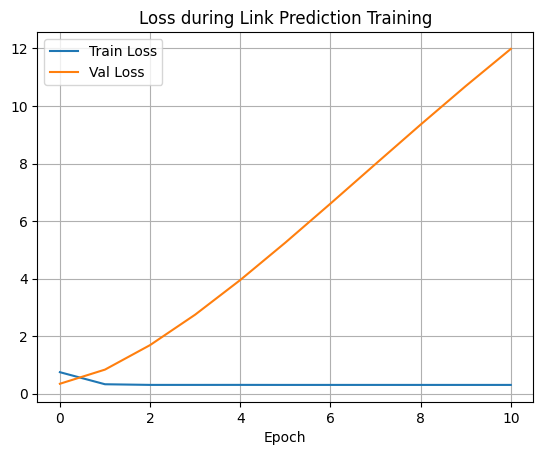

==================== Norm: layer, Dropout: 0.5, Skip: False ====================
Epoch 000, Train Loss: 0.7764, Val Loss: 0.3645, Val AUC: 0.5645
Epoch 001, Train Loss: 0.4612, Val Loss: 0.5809, Val AUC: 0.5296
Epoch 002, Train Loss: 0.3863, Val Loss: 1.1361, Val AUC: 0.5098
Epoch 003, Train Loss: 0.3600, Val Loss: 1.8538, Val AUC: 0.4551
Epoch 004, Train Loss: 0.3474, Val Loss: 2.6796, Val AUC: 0.4775
Epoch 005, Train Loss: 0.3347, Val Loss: 3.5789, Val AUC: 0.5187
Epoch 006, Train Loss: 0.3318, Val Loss: 4.5178, Val AUC: 0.5667
Epoch 007, Train Loss: 0.3256, Val Loss: 5.4658, Val AUC: 0.5825
Epoch 008, Train Loss: 0.3242, Val Loss: 6.4010, Val AUC: 0.5818
Epoch 009, Train Loss: 0.3264, Val Loss: 7.3039, Val AUC: 0.5805
Epoch 010, Train Loss: 0.3325, Val Loss: 8.1603, Val AUC: 0.5798
Epoch 011, Train Loss: 0.3316, Val Loss: 8.9583, Val AUC: 0.5840
Epoch 012, Train Loss: 0.3233, Val Loss: 9.6911, Val AUC: 0.5964
Epoch 013, Train Loss: 0.3331, Val Loss: 10.3561, Val AUC: 0.5854
Epoch 01

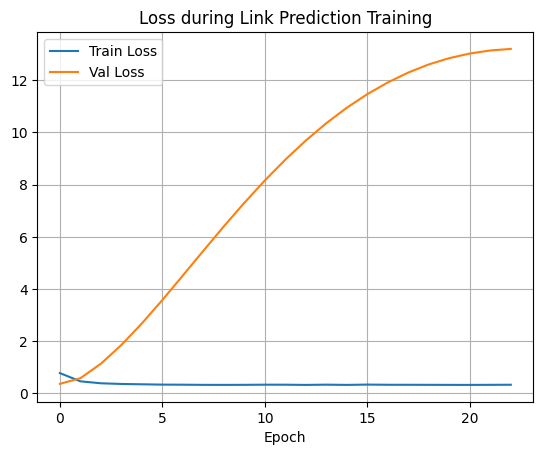

==================== Norm: layer, Dropout: 0.5, Skip: True ====================
Epoch 000, Train Loss: 0.8522, Val Loss: 0.3250, Val AUC: 0.5242
Epoch 001, Train Loss: 0.3970, Val Loss: 0.5571, Val AUC: 0.5474
Epoch 002, Train Loss: 0.3514, Val Loss: 1.1272, Val AUC: 0.5511
Epoch 003, Train Loss: 0.3425, Val Loss: 1.8561, Val AUC: 0.5684
Epoch 004, Train Loss: 0.3405, Val Loss: 2.6961, Val AUC: 0.5865
Epoch 005, Train Loss: 0.3361, Val Loss: 3.6087, Val AUC: 0.5416
Epoch 006, Train Loss: 0.3360, Val Loss: 4.5618, Val AUC: 0.5367
Epoch 007, Train Loss: 0.3268, Val Loss: 5.5289, Val AUC: 0.5335
Epoch 008, Train Loss: 0.3259, Val Loss: 6.4859, Val AUC: 0.5323
Epoch 009, Train Loss: 0.3227, Val Loss: 7.4100, Val AUC: 0.5310
Epoch 010, Train Loss: 0.3148, Val Loss: 8.2852, Val AUC: 0.5305
Epoch 011, Train Loss: 0.3235, Val Loss: 9.0997, Val AUC: 0.5326
Epoch 012, Train Loss: 0.3279, Val Loss: 9.8418, Val AUC: 0.5290
Epoch 013, Train Loss: 0.3238, Val Loss: 10.5036, Val AUC: 0.5319
Epoch 014

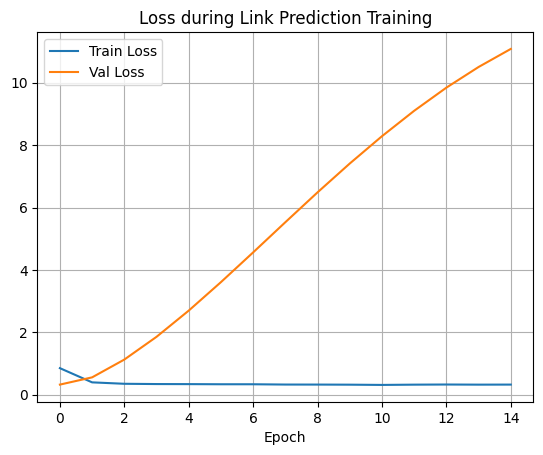

==================== Norm: pair, Dropout: 0.0, Skip: False ====================
Epoch 000, Train Loss: 0.7473, Val Loss: 0.4124, Val AUC: 0.5173
Epoch 001, Train Loss: 0.7395, Val Loss: 0.3907, Val AUC: 0.4852
Epoch 002, Train Loss: 0.7354, Val Loss: 0.5043, Val AUC: 0.4861
Epoch 003, Train Loss: 0.7302, Val Loss: 0.6167, Val AUC: 0.5041
Epoch 004, Train Loss: 0.7256, Val Loss: 0.6875, Val AUC: 0.5470
Epoch 005, Train Loss: 0.7214, Val Loss: 0.7119, Val AUC: 0.5326
Epoch 006, Train Loss: 0.7172, Val Loss: 0.6974, Val AUC: 0.5116
Epoch 007, Train Loss: 0.7130, Val Loss: 0.6551, Val AUC: 0.4961
Epoch 008, Train Loss: 0.7088, Val Loss: 0.5959, Val AUC: 0.4956
Epoch 009, Train Loss: 0.7046, Val Loss: 0.5304, Val AUC: 0.5008
Epoch 010, Train Loss: 0.7004, Val Loss: 0.4673, Val AUC: 0.5147
Epoch 011, Train Loss: 0.6963, Val Loss: 0.4137, Val AUC: 0.5284
Epoch 012, Train Loss: 0.6922, Val Loss: 0.3747, Val AUC: 0.5380
Epoch 013, Train Loss: 0.6882, Val Loss: 0.3532, Val AUC: 0.5573
Epoch 014,

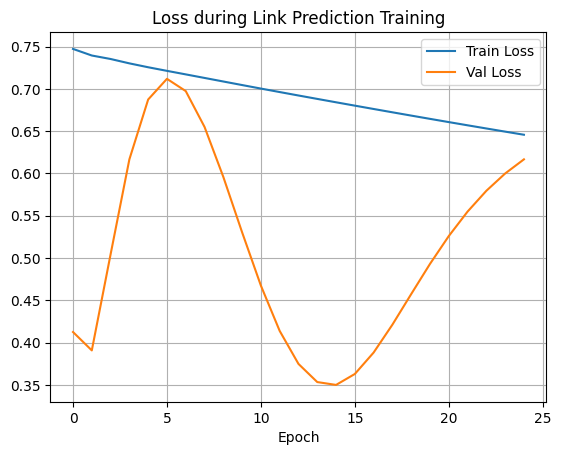

==================== Norm: pair, Dropout: 0.0, Skip: True ====================
Epoch 000, Train Loss: 0.6328, Val Loss: 0.4831, Val AUC: 0.5071
Epoch 001, Train Loss: 0.6269, Val Loss: 0.3755, Val AUC: 0.4765
Epoch 002, Train Loss: 0.6228, Val Loss: 0.3674, Val AUC: 0.4905
Epoch 003, Train Loss: 0.6190, Val Loss: 0.3843, Val AUC: 0.5320
Epoch 004, Train Loss: 0.6154, Val Loss: 0.3961, Val AUC: 0.5120
Epoch 005, Train Loss: 0.6118, Val Loss: 0.3951, Val AUC: 0.4614
Epoch 006, Train Loss: 0.6082, Val Loss: 0.3846, Val AUC: 0.4554
Epoch 007, Train Loss: 0.6047, Val Loss: 0.3716, Val AUC: 0.4371
Epoch 008, Train Loss: 0.6012, Val Loss: 0.3629, Val AUC: 0.3865
Epoch 009, Train Loss: 0.5977, Val Loss: 0.3637, Val AUC: 0.3911
Epoch 010, Train Loss: 0.5943, Val Loss: 0.3764, Val AUC: 0.4218
Epoch 011, Train Loss: 0.5909, Val Loss: 0.4007, Val AUC: 0.4051
Epoch 012, Train Loss: 0.5875, Val Loss: 0.4337, Val AUC: 0.3708
Epoch 013, Train Loss: 0.5841, Val Loss: 0.4712, Val AUC: 0.3928
Early stopp

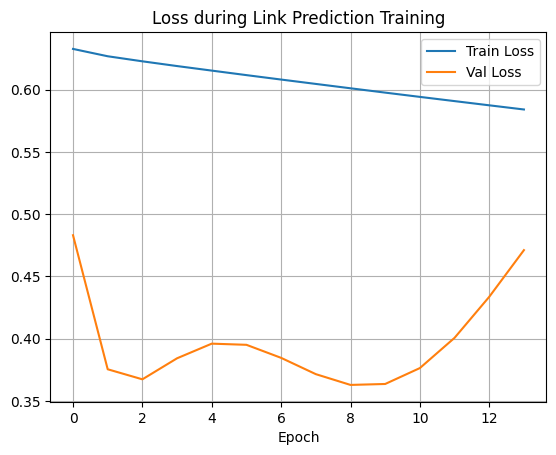

==================== Norm: pair, Dropout: 0.5, Skip: False ====================
Epoch 000, Train Loss: 0.6606, Val Loss: 0.5823, Val AUC: 0.4971
Epoch 001, Train Loss: 0.6540, Val Loss: 0.4949, Val AUC: 0.4964
Epoch 002, Train Loss: 0.6518, Val Loss: 0.4182, Val AUC: 0.5034
Epoch 003, Train Loss: 0.6457, Val Loss: 0.3634, Val AUC: 0.5010
Epoch 004, Train Loss: 0.6421, Val Loss: 0.3402, Val AUC: 0.4816
Epoch 005, Train Loss: 0.6373, Val Loss: 0.3348, Val AUC: 0.4653
Epoch 006, Train Loss: 0.6334, Val Loss: 0.3413, Val AUC: 0.4553
Epoch 007, Train Loss: 0.6294, Val Loss: 0.3516, Val AUC: 0.4436
Epoch 008, Train Loss: 0.6262, Val Loss: 0.3642, Val AUC: 0.4549
Epoch 009, Train Loss: 0.6220, Val Loss: 0.3740, Val AUC: 0.4480
Epoch 010, Train Loss: 0.6184, Val Loss: 0.3817, Val AUC: 0.4421
Epoch 011, Train Loss: 0.6151, Val Loss: 0.3846, Val AUC: 0.4666
Epoch 012, Train Loss: 0.6107, Val Loss: 0.3839, Val AUC: 0.4748
Early stopping at epoch 12 (best AUC = 0.5034)
Loading the best model weigh

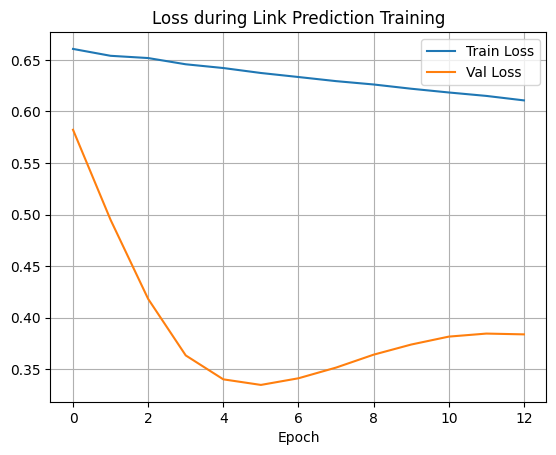

==================== Norm: pair, Dropout: 0.5, Skip: True ====================
Epoch 000, Train Loss: 0.6898, Val Loss: 0.5548, Val AUC: 0.4920
Epoch 001, Train Loss: 0.6799, Val Loss: 0.4645, Val AUC: 0.4658
Epoch 002, Train Loss: 0.6795, Val Loss: 0.3821, Val AUC: 0.4588
Epoch 003, Train Loss: 0.6729, Val Loss: 0.3368, Val AUC: 0.4707
Epoch 004, Train Loss: 0.6675, Val Loss: 0.3200, Val AUC: 0.4667
Epoch 005, Train Loss: 0.6648, Val Loss: 0.3190, Val AUC: 0.4806
Epoch 006, Train Loss: 0.6609, Val Loss: 0.3240, Val AUC: 0.4997
Epoch 007, Train Loss: 0.6568, Val Loss: 0.3296, Val AUC: 0.5121
Epoch 008, Train Loss: 0.6527, Val Loss: 0.3363, Val AUC: 0.5097
Epoch 009, Train Loss: 0.6479, Val Loss: 0.3407, Val AUC: 0.5136
Epoch 010, Train Loss: 0.6445, Val Loss: 0.3444, Val AUC: 0.5249
Epoch 011, Train Loss: 0.6417, Val Loss: 0.3458, Val AUC: 0.5314
Epoch 012, Train Loss: 0.6374, Val Loss: 0.3462, Val AUC: 0.5290
Epoch 013, Train Loss: 0.6334, Val Loss: 0.3456, Val AUC: 0.5334
Epoch 014, 

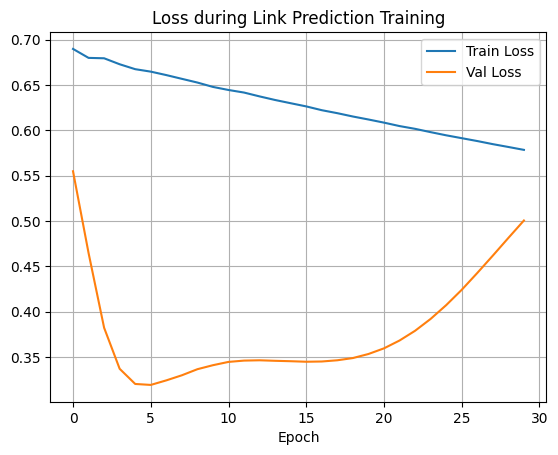

Normalization      Dropout  Skip Connections      Val Acc    Test Acc    Test AP
---------------  ---------  ------------------  ---------  ----------  ---------
none                   0    False                0.625529    0.671668   0.95403
none                   0    True                 0.627719    0.680975   0.956418
none                   0.5  False                0.631733    0.678691   0.955791
none                   0.5  True                 0.62261     0.682519   0.956446
batch                  0    False                0.455189    0.515459   0.922883
batch                  0    True                 0.554919    0.559869   0.932762
batch                  0.5  False                0.447708    0.591767   0.939737
batch                  0.5  True                 0.466228    0.566292   0.93646
layer                  0    False                0.537659    0.511587   0.925734
layer                  0    True                 0.418205    0.41541    0.888739
layer                  0.5  Fa

In [18]:
results = []

for normalization in ['none', 'batch', 'layer', 'pair']:
    for dropout in [0.0, 0.5]:
        for skip_connections in [False, True]:
            print("=" * 20 + f" Norm: {normalization}, Dropout: {dropout}, Skip: {skip_connections} " + "=" * 20)
            encoder = GCNEncoder(in_channels=dataset.num_features, out_channels=32).to(device)
            decoder = MLPDecoder(
                in_channels=32,
                normalization=normalization,
                dropout=dropout,
                use_skip_connections=skip_connections,
            ).to(device)
            val_acc, test_acc, test_ap = train_and_evaluate_link_model(encoder, decoder, train_data, val_data, test_data)
            results.append([normalization, dropout, skip_connections, val_acc, test_acc, test_ap])

print(tabulate(results, headers=["Normalization", "Dropout", "Skip Connections", "Val Acc", "Test Acc", "Test AP"]))

**Лучшая конфигурация:**
- Normalization: None
- Dropout: 0.5
- Skip Connections: False

> В этот раз, конфигурация оказалось совершенно иной: **Residual connections** и **Normalization** показались существенное ухудшение качества и стабильности обучения, однако **Dropout** на высоком уровне помог справиться с переобучением, что привело к лучшему результату.

### 2.4 Реализация и сравнение GCN / GraphSAGE / GAT / GIN
Выберите 2 базовые архитектуры из списка: GraphSAGE, GAT(v2), GIN. Реализуйте их для задачи node classification и сравните полученные результаты.

Комментарий: при реализации, можно использовать наработки с предыдущих пунктов - добавлять разные виды модификаций (увеличивать число слоев / добавлять слои нормализации / residual conections...)


==================== Architecture: gcn ====================
Epoch 000, Train Loss: 0.7741, Val Loss: 0.3783, Val AUC: 0.6144
Epoch 001, Train Loss: 0.7237, Val Loss: 0.5488, Val AUC: 0.6141
Epoch 002, Train Loss: 0.6021, Val Loss: 1.5615, Val AUC: 0.6179
Epoch 003, Train Loss: 0.4272, Val Loss: 3.8691, Val AUC: 0.6211
Epoch 004, Train Loss: 0.2879, Val Loss: 7.7118, Val AUC: 0.6229
Epoch 005, Train Loss: 0.3552, Val Loss: 9.2526, Val AUC: 0.6233
Epoch 006, Train Loss: 0.4040, Val Loss: 8.5703, Val AUC: 0.6240
Epoch 007, Train Loss: 0.3576, Val Loss: 7.0253, Val AUC: 0.6239
Epoch 008, Train Loss: 0.3008, Val Loss: 5.5116, Val AUC: 0.6241
Epoch 009, Train Loss: 0.2802, Val Loss: 4.4719, Val AUC: 0.6244
Epoch 010, Train Loss: 0.2998, Val Loss: 3.9462, Val AUC: 0.6243
Epoch 011, Train Loss: 0.3208, Val Loss: 3.8243, Val AUC: 0.6252
Epoch 012, Train Loss: 0.3213, Val Loss: 4.0232, Val AUC: 0.6246
Epoch 013, Train Loss: 0.3070, Val Loss: 4.4870, Val AUC: 0.6251
Epoch 014, Train Loss: 0.2868,

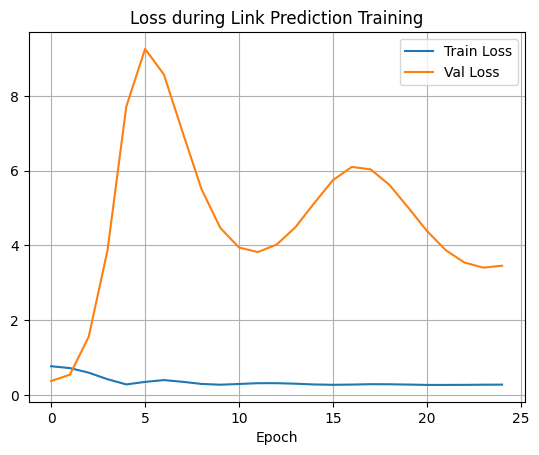

==================== Architecture: sage ====================
Epoch 000, Train Loss: 0.7668, Val Loss: 0.4869, Val AUC: 0.5291
Epoch 001, Train Loss: 0.6684, Val Loss: 2.3988, Val AUC: 0.5264
Epoch 002, Train Loss: 0.4709, Val Loss: 8.4406, Val AUC: 0.5242
Epoch 003, Train Loss: 0.2981, Val Loss: 18.2273, Val AUC: 0.5248
Epoch 004, Train Loss: 0.4327, Val Loss: 17.6809, Val AUC: 0.5276
Epoch 005, Train Loss: 0.3932, Val Loss: 13.3442, Val AUC: 0.5286
Epoch 006, Train Loss: 0.2972, Val Loss: 10.0787, Val AUC: 0.5291
Epoch 007, Train Loss: 0.3333, Val Loss: 8.6612, Val AUC: 0.5316
Epoch 008, Train Loss: 0.3533, Val Loss: 8.5340, Val AUC: 0.5330
Epoch 009, Train Loss: 0.3207, Val Loss: 9.3541, Val AUC: 0.5329
Epoch 010, Train Loss: 0.2938, Val Loss: 10.5724, Val AUC: 0.5325
Epoch 011, Train Loss: 0.2914, Val Loss: 11.3440, Val AUC: 0.5315
Epoch 012, Train Loss: 0.2986, Val Loss: 11.0235, Val AUC: 0.5339
Epoch 013, Train Loss: 0.3002, Val Loss: 9.7867, Val AUC: 0.5332
Epoch 014, Train Loss:

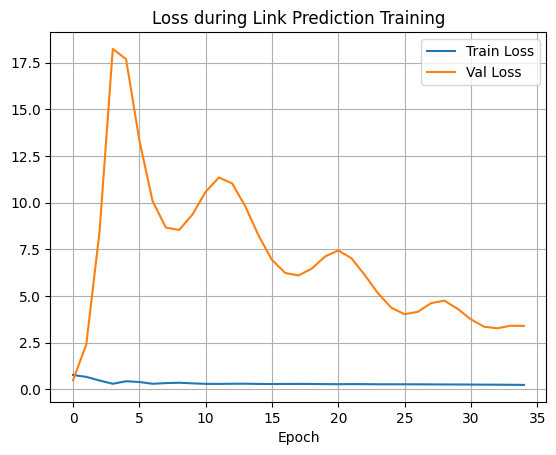

==================== Architecture: gatv2 ====================
Epoch 000, Train Loss: 0.7473, Val Loss: 0.6560, Val AUC: 0.4869
Epoch 001, Train Loss: 0.7241, Val Loss: 0.5784, Val AUC: 0.5220
Epoch 002, Train Loss: 0.6928, Val Loss: 0.3905, Val AUC: 0.5301
Epoch 003, Train Loss: 0.6281, Val Loss: 0.4511, Val AUC: 0.5324
Epoch 004, Train Loss: 0.5063, Val Loss: 1.2671, Val AUC: 0.5377
Epoch 005, Train Loss: 0.3454, Val Loss: 3.2240, Val AUC: 0.5445
Epoch 006, Train Loss: 0.3355, Val Loss: 4.3646, Val AUC: 0.5500
Epoch 007, Train Loss: 0.4066, Val Loss: 3.8569, Val AUC: 0.5494
Epoch 008, Train Loss: 0.3756, Val Loss: 2.7600, Val AUC: 0.5477
Epoch 009, Train Loss: 0.3171, Val Loss: 1.8065, Val AUC: 0.5471
Epoch 010, Train Loss: 0.3058, Val Loss: 1.2550, Val AUC: 0.5503
Epoch 011, Train Loss: 0.3311, Val Loss: 1.0288, Val AUC: 0.5545
Epoch 012, Train Loss: 0.3495, Val Loss: 0.9993, Val AUC: 0.5582
Epoch 013, Train Loss: 0.3464, Val Loss: 1.1069, Val AUC: 0.5597
Epoch 014, Train Loss: 0.328

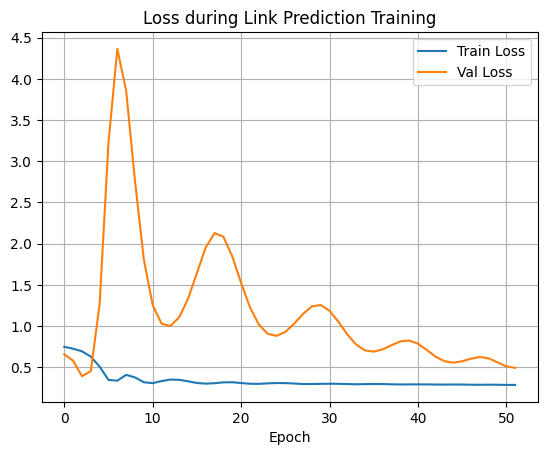

Architecture      Val Acc    Test Acc    Test AP
--------------  ---------  ----------  ---------
gcn              0.620311    0.685272   0.956362
sage             0.529065    0.550882   0.927639
gatv2            0.576887    0.56306    0.933383


In [19]:
results = []

for architecture in ['gcn', 'sage', 'gatv2']:
    print("=" * 20 + f" Architecture: {architecture} " + "=" * 20)
    encoder = GCNEncoder(in_channels=dataset.num_features, out_channels=32, conv_type=architecture, gatv2_heads=4).to(device)
    decoder = MLPDecoder(
        in_channels=32,
        use_skip_connections=True,
    ).to(device)
    val_acc, test_acc, test_ap = train_and_evaluate_link_model(encoder, decoder, train_data, val_data, test_data)
    results.append([architecture, val_acc, test_acc, test_ap])

print(tabulate(results, headers=["Architecture", "Val Acc", "Test Acc", "Test AP"]))

> **GCN** вновь показал лучший результат, однако его стабильность уступает остальным моделям.
>
> **GATv2** показал весьма сильную просадку, однако его обучение самое стабильное и предсказуемое.
>
> **GraphSAGE** немного отстаёт от GATv2, вероятно, потому что его выборка соседей менее стабильна для задачи предсказания рёбер.